Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
import keras as k
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report
!pip install tensorflow-addons
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode
!pip install transformers

BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].replace("_CWR","")

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.8 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=b786980a432da05e20d49fb257bb1d78d66ae57b76a9172ddbbf54bc9985ea7b
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 27.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 24.8 MB/s 
     |████████████████████████████████| 7.6 MB 64.7 MB/s 
     |████████████████████████████████| 163 kB 71.2 MB/s 
[24619, 1660, 27462]
[3, 2, 3]
[10684, 18894, 19405, 13505

In [2]:
from transformers import pipeline, AutoTokenizer
from future.utils import iteritems

tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    unmasker = pipeline('fill-mask', model='allenai/scibert_scivocab_uncased')
    
    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))

    valid_dataset_idxs = [i for i,labels in enumerate(labels) if tag2idx["O"] in labels]
    valid_dataset_sents = [sent for i,sent in enumerate(dataset) if i in valid_dataset_idxs]
    valid_dataset_labels = [labels for i,labels in enumerate(labels) if i in valid_dataset_idxs]

    random_idxs = np.random.choice(len(valid_dataset_sents), number_of_new_sentences, replace=True)
    base_labels = [valid_dataset_labels[i] for i in random_idxs]

    if not all([tag2idx["O"] in labels for labels in base_labels]):
        raise Exception("Sentence without 'O'-tagged token in the dataset!!!")

    base_sequences = [valid_dataset_sents[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
      sequence_str = [idx2word[word] for word in sequence]

      # check max number of tokens bert support and truncate sentence before augmentation
      # augmented sentence will be shorter than original sentence if higher than bert limit
      encoding = tokenizer(sequence_str,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             truncation=True, 
                             max_length=512)
      
      max_n_of_tokens = len([mapping for mapping in encoding["offset_mapping"] if mapping[0] == 0 and mapping[1] != 0])

      truncated_sequence_str = sequence_str[:max_n_of_tokens]
      truncated_labels = base_labels[k][:max_n_of_tokens]

      # print(len(sequence_str),len(truncated_sequence_str),len(base_labels[k]),len(truncated_labels))

      replaceable_indices = [i for i,label in enumerate(truncated_labels) if label == tag2idx["O"]]
      replace_percent = round(random.uniform(0.1, 1), 1)
      replace_qty = max(math.floor(replace_percent*len(replaceable_indices)), 1)
      replace_indices = random.sample(replaceable_indices, k=replace_qty)
      replace_indices.sort()

      masked_text_list = ["[MASK]" if i in replace_indices else word for i,word in enumerate(truncated_sequence_str)]
      new_mask_sent = ' '.join(masked_text_list)
      augmented_text_list = unmasker(new_mask_sent)

      augmented_sentence = truncated_sequence_str.copy()
      if len(replace_indices) == 1:
        augmented_text_list = [augmented_text_list]

      for i,index in enumerate(replace_indices):
        available_words = [word["token_str"] for word in augmented_text_list[i] if word["token_str"] != truncated_sequence_str[index]]
        new_word = random.choice(available_words)
        if new_word != "[UNK]":
          augmented_sentence[index] = new_word

      # print("Original text->",len(sequence_str),sequence_str)
      # print("Augmented text->",len(sequence_str),augmented_sentence)

      new_sequences.append(augmented_sentence)
      new_labels.append(truncated_labels)

    all_words = list(set([word for seq in new_sequences for word in seq]))
    updated_word2idx = word2idx.copy()
    updated_idx2word = idx2word.copy()
    for word in all_words:
      try:
        updated_word2idx[word]
      except:
        updated_word2idx[word] = len(updated_word2idx)
    updated_idx2word = {i: w for w, i in iteritems(updated_word2idx)}

    updated_n_words = len(updated_idx2word.items())

    new_sequences = [[updated_word2idx[word] for word in seq] for seq in new_sequences]

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [3]:
# Graph plot function 
plt.style.use('ggplot')

def plot_history(history):
    # accuracy = history.history['crf_viterbi_accuracy']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [4]:
# This function converts predicted values to labels from idx2tag
# This is to improve the interpretability of the results
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

In [5]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -oq glove.6B.zip

--2022-11-02 22:29:20--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-11-02 22:29:20--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-11-02 22:29:20--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [6]:
path_to_glove_file = "./glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [7]:
embedding_dim = 100

def generate_embedding_matrix(n_words, word2idx):
  num_tokens = n_words + 1
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word2idx.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # Words not found in embedding index will be all-zeros.
          # This includes the representation for "padding" and "OOV"
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))
  return embedding_matrix

In [8]:
class CRF(L.Layer):
    def __init__(self,
                 output_dim,
                 sparse_target=True,
                 **kwargs):
        """    
        Args:
            output_dim (int): the number of labels to tag each temporal input.
            sparse_target (bool): whether the the ground-truth label represented in one-hot.
        Input shape:
            (batch_size, sentence length, output_dim)
        Output shape:
            (batch_size, sentence length, output_dim)
        """
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim) 
        self.sparse_target = sparse_target
        self.input_spec = L.InputSpec(min_ndim=3)
        self.supports_masking = False
        self.sequence_lengths = None
        self.transitions = None

    def build(self, input_shape):
        assert len(input_shape) == 3
        f_shape = tf.TensorShape(input_shape)
        input_spec = L.InputSpec(min_ndim=3, axes={-1: f_shape[-1]})

        if f_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `CRF` '
                             'should be defined. Found `None`.')
        if f_shape[-1] != self.output_dim:
            raise ValueError('The last dimension of the input shape must be equal to output'
                             ' shape. Use a linear layer if needed.')
        self.input_spec = input_spec
        self.transitions = self.add_weight(name='transitions',
                                           shape=[self.output_dim, self.output_dim],
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.built = True

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or
        # manipulate it if this layer changes the shape of the input
        return mask

    def call(self, inputs, sequence_lengths=None, training=None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype=self.dtype)
        if sequence_lengths is not None:
            assert len(sequence_lengths.shape) == 2
            assert tf.convert_to_tensor(sequence_lengths).dtype == 'int32'
            seq_len_shape = tf.convert_to_tensor(sequence_lengths).get_shape().as_list()
            assert seq_len_shape[1] == 1
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype=tf.int32) * (
                tf.shape(inputs)[1]
            )

        viterbi_sequence, _ = crf_decode(sequences,
                                         self.transitions,
                                         self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred, dtype=self.dtype)
            log_likelihood, self.transitions = crf_log_likelihood(
                y_pred,
                tf.cast(K.argmax(y_true), dtype=tf.int32) if self.sparse_target else y_true,
                self.sequence_lengths,
                transition_params=self.transitions,
            )
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            # -1e10 to avoid zero at sum(mask)
            mask = K.cast(
                K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * (shape[1])
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            if self.sparse_target:
                y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

    def compute_output_shape(self, input_shape):
        tf.TensorShape(input_shape).assert_has_rank(3)
        return input_shape[:2] + (self.output_dim,)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'sparse_target': self.sparse_target,
            'supports_masking': self.supports_masking,
            'transitions': K.eval(self.transitions)
        }
        base_config = super(CRF, self).get_config()
        return dict(base_config, **config)

In [9]:
# Model creation function
def create_model(maxlen, n_words, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=n_words+1, output_dim=embedding_dim, 
                    input_length=maxlen, weights=[embedding_matrix], mask_zero=True))
    model.add(Bidirectional(LSTM(units=embedding_dim, return_sequences=True, 
                              dropout=0.1)))
    model.add(TimeDistributed(Dense(n_tags)))
    crf = CRF(n_tags, sparse_target=True)
    model.add(crf)
    adam = Adam(learning_rate=0.005)
    model.compile(optimizer=adam, loss=crf.loss, metrics=[crf.accuracy, 'accuracy'])
    model.summary()
    return model

In [10]:
# Model training function
def train(model, X_train_df, y_train_df, X_dev_df, y_dev_df):
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
  callbacks_list = [early_stopping]

  batch_size = round(0.05*len(X_train_df))
  if batch_size > 16:
    batch_size = 16
  if batch_size < 10:
    batch_size = 10

  history = model.fit(X_train_df, np.array(y_train_df),
                      batch_size=batch_size,
                      epochs=500,
                      validation_data=(X_dev_df,  np.array(y_dev_df)),
                      validation_batch_size=512,
                      verbose=1,
                      callbacks=callbacks_list)
  plot_history(history)

In [11]:
# Model testing function
def test(model, X_test_df, y_test_df):
  test_pred = model.predict(X_test_df, verbose=1)   

  pred_labels = pred2label(test_pred)
  test_labels = pred2label(y_test_df)
  
  print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
  report = classification_report(y_pred=pred_labels, y_true=test_labels, output_dict=True)
  df = pd.DataFrame(report).transpose()
  print("Classification Report:")
  print(df.to_csv())

In [12]:
def create_train_and_validate_model(augmented_percentage):
  augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx = generate_sentences(X_train, y_train, augmented_percentage)

  # Preparing data for training. 
  # X = observations vector. For text sequence labeling, observations are the index of the words in the sentences
  # y = labels vector. For text sequence labeling, labels are the index of tags in the sentences
  # The BI-LSTM layer expects all texts/sentences to be of the same length. 
  # So, we need to pad shorter sentences
  # We select the padding size to be the length of the longest sentence.

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_dev = max([len(s) for s in y_dev])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_y_test = max([len(s) for s in y_test])

  maxlen = max([maxlen_X_train, maxlen_y_train, maxlen_X_dev, maxlen_y_dev, maxlen_X_test, maxlen_y_test])

  augmented_X_train = pad_sequences(maxlen=maxlen, sequences=augmented_X_train, padding="post",value=updated_word2idx["PAD"])
  new_X_dev = pad_sequences(maxlen=maxlen, sequences=X_dev, padding="post",value=updated_word2idx["PAD"])
  new_X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=updated_word2idx["PAD"])

  augmented_y_train = pad_sequences(maxlen=maxlen, sequences=augmented_y_train, padding="post", value=tag2idx["O"])
  new_y_dev = pad_sequences(maxlen=maxlen, sequences=y_dev, padding="post", value=tag2idx["O"])
  new_y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])

  # Converts vector y (integers) to binary matrix.
  # Each y is a one-hot vector where only the position of the tag gests "1"
  augmented_y_train = [to_categorical(i, num_classes=n_tags) for i in augmented_y_train]
  new_y_dev = [to_categorical(i, num_classes=n_tags) for i in new_y_dev]
  new_y_test = [to_categorical(i, num_classes=n_tags) for i in new_y_test]

  embedding_matrix = generate_embedding_matrix(updated_n_words, updated_word2idx)

  model = None
  model = create_model(maxlen, updated_n_words, embedding_matrix)

  train(model, augmented_X_train, augmented_y_train, new_X_dev, new_y_dev)

  test(model, new_X_test, new_y_test)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4334
Points in y_train after augmentation: 4334
Converted 10430 words (18091 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 204, 100)          2852100   
                                                                 
 bidirectional (Bidirectiona  (None, 204, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 204, 7)           1407      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 204, 7)            49        
                                                                 
Total params: 3,014,356
Trainable params: 3,014,356
Non-trainable

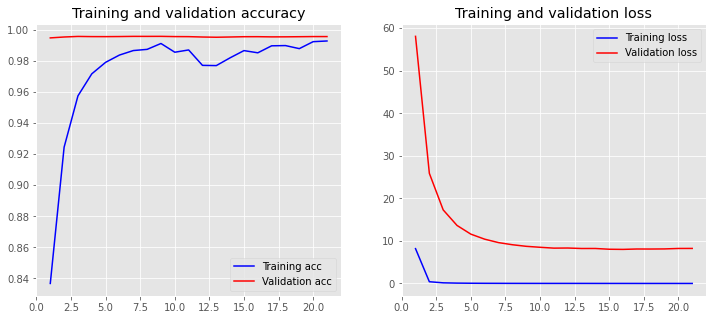

864/864 [==============================] - 67s 74ms/step
F1-score: 67.4%
Classification Report:
,precision,recall,f1-score,support
problem,0.6685230024213075,0.6599474145486416,0.6642075297702578,12551.0
test,0.6932561380937065,0.7174877940523746,0.7051638584437537,9012.0
treatment,0.6866760828625236,0.6261672212085435,0.6550272273059002,9317.0
micro avg,0.6812630324694667,0.6665479274611399,0.6738251518177205,30880.0
macro avg,0.6828184077925125,0.6678674766031866,0.6747995385066372,30880.0
weighted avg,0.6812181860077865,0.6665479274611399,0.6733903521778071,30880.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4334
Points in y_train after augmentation: 4334
Converted 10425 words (18087 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 204, 100)          2851200   
                                                                 
 bidirectional_1 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,013,456
Trainable params: 3,013,456
Non-trainab

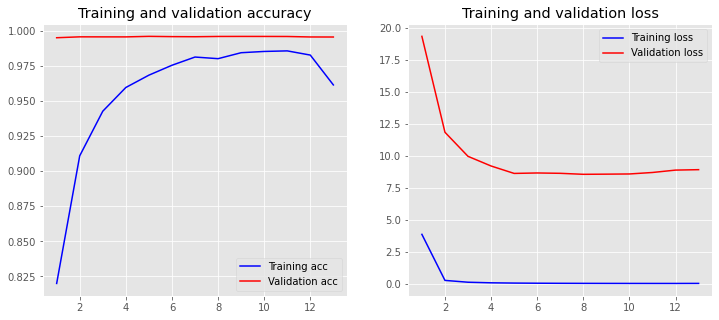

864/864 [==============================] - 64s 71ms/step
F1-score: 68.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.7003864319450408,0.6498286989084535,0.6741610183501405,12551.0
test,0.7319707351062594,0.6994007989347537,0.7153152130738241,9012.0
treatment,0.7004570491034806,0.6415155092841043,0.6696918767507003,9317.0
micro avg,0.7098544583000451,0.6617875647668394,0.6849787997117431,30880.0
macro avg,0.7109380720515937,0.6635816690424372,0.6863893693915549,30880.0
weighted avg,0.7096252816909633,0.6617875647668394,0.6848230199877005,30880.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4334
Points in y_train after augmentation: 4334
Converted 10423 words (18087 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 204, 100)          2851000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,013,256
Trainable params: 3,013,256
Non-trainab

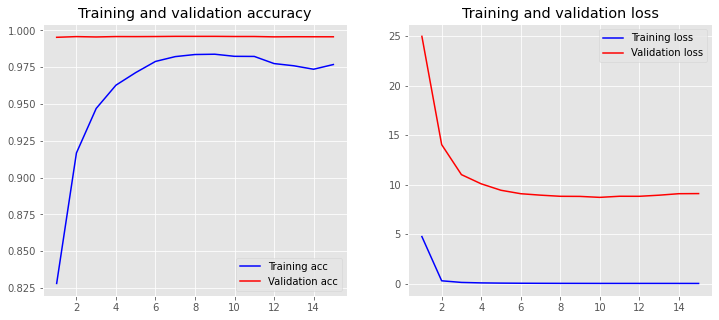

864/864 [==============================] - 65s 71ms/step
F1-score: 66.7%
Classification Report:
,precision,recall,f1-score,support
problem,0.6478992894655545,0.668392956736515,0.6579865877093218,12551.0
test,0.7342623738587217,0.6782068353306702,0.705122288878634,9012.0
treatment,0.626653205451792,0.6662015670280134,0.6458224950577464,9317.0
micro avg,0.6642075889277352,0.6705958549222798,0.6673864350516462,30880.0
macro avg,0.6696049562586895,0.6709337863650662,0.6696437905485674,30880.0
weighted avg,0.6666931480081386,0.6705958549222798,0.6680725361453035,30880.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4334
Points in y_train after augmentation: 4334
Converted 10425 words (18071 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 204, 100)          2849600   
                                                                 
 bidirectional_3 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,011,856
Trainable params: 3,011,856
Non-trainab

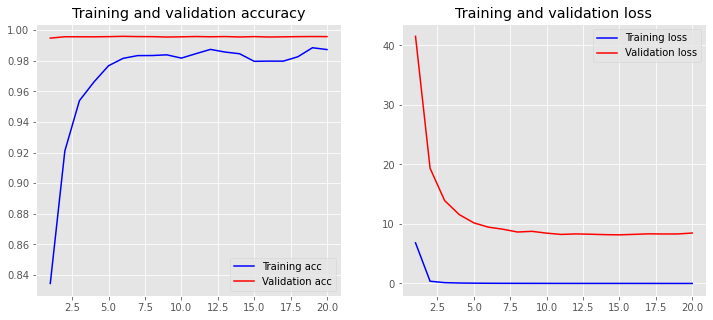

864/864 [==============================] - 65s 72ms/step
F1-score: 67.3%
Classification Report:
,precision,recall,f1-score,support
problem,0.6600880641610316,0.6688710062943192,0.6644505124856545,12551.0
test,0.7099409895596913,0.6941855304039058,0.7019748653500897,9012.0
treatment,0.6652298850574713,0.6460233980895138,0.6554859787639531,9317.0
micro avg,0.6759761920334881,0.6693652849740933,0.6726544957531974,30880.0
macro avg,0.678419646259398,0.6696933115959128,0.673970452199899,30880.0
weighted avg,0.6761884821981057,0.6693652849740933,0.6726968501582321,30880.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4334
Points in y_train after augmentation: 4334
Converted 10420 words (18083 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 204, 100)          2850300   
                                                                 
 bidirectional_4 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,012,556
Trainable params: 3,012,556
Non-trainab

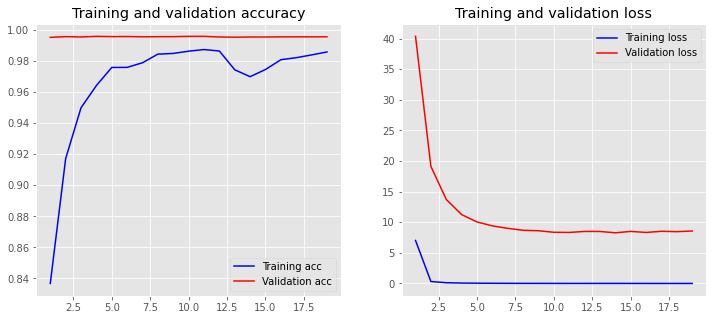

864/864 [==============================] - 66s 73ms/step
F1-score: 64.3%
Classification Report:
,precision,recall,f1-score,support
problem,0.6259824318076745,0.6472791012668313,0.636452661678875,12551.0
test,0.7467981557377049,0.6470261873058145,0.6933412604042807,9012.0
treatment,0.5699953117674637,0.6524632392400987,0.6084476028425584,9317.0
micro avg,0.6369908746939684,0.6487694300518134,0.6428262020503442,30880.0
macro avg,0.6475919664376144,0.6489228426042483,0.6460805083085713,30880.0
weighted avg,0.6443489896652778,0.6487694300518134,0.6446054116314461,30880.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4334
Points in y_train after augmentation: 4334
Converted 10422 words (18082 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 204, 100)          2850400   
                                                                 
 bidirectional_5 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,012,656
Trainable params: 3,012,656
Non-trainab

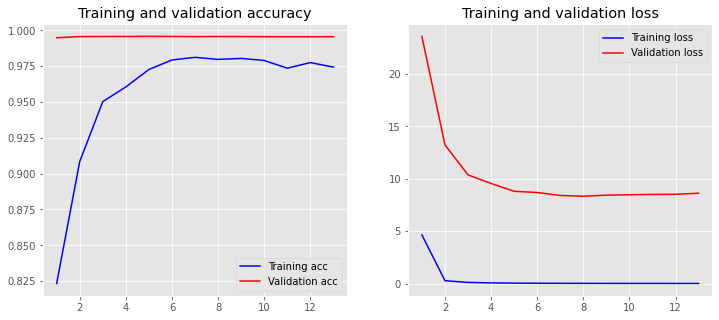

864/864 [==============================] - 66s 73ms/step
F1-score: 67.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.6352983725135624,0.6997848776989881,0.6659842280861389,12551.0
test,0.7226480062201488,0.7219263204616068,0.7222869830696641,9012.0
treatment,0.6807242990654205,0.625415906407642,0.6518990882139061,9317.0
micro avg,0.6727411749713266,0.6838082901554404,0.6782295882315154,30880.0
macro avg,0.6795568925997105,0.6823757015227456,0.6800567664565698,30880.0
weighted avg,0.6744961787521445,0.6838082901554404,0.678165872507186,30880.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4334
Points in y_train after augmentation: 4334
Converted 10424 words (18091 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 204, 100)          2851500   
                                                                 
 bidirectional_6 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,013,756
Trainable params: 3,013,756
Non-trainab

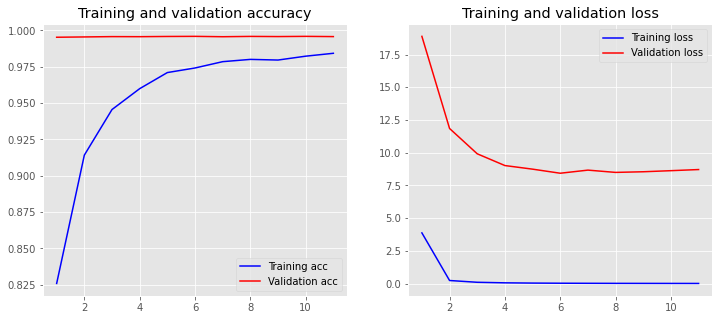

864/864 [==============================] - 66s 73ms/step
F1-score: 68.9%
Classification Report:
,precision,recall,f1-score,support
problem,0.6629342741007745,0.6887100629431918,0.6755763970300899,12551.0
test,0.7130164846927852,0.7391256102973812,0.7258363299553231,9012.0
treatment,0.6864549433284705,0.6565418053021359,0.6711652402896643,9317.0
micro avg,0.6845839192125783,0.6937176165803108,0.6891205044071287,30880.0
macro avg,0.6874685673740101,0.6947924928475696,0.6908593224250258,30880.0
weighted avg,0.6846468050933148,0.6937176165803108,0.6889133066211409,30880.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4334
Points in y_train after augmentation: 4334
Converted 10434 words (18082 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 204, 100)          2851600   
                                                                 
 bidirectional_7 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,013,856
Trainable params: 3,013,856
Non-trainab

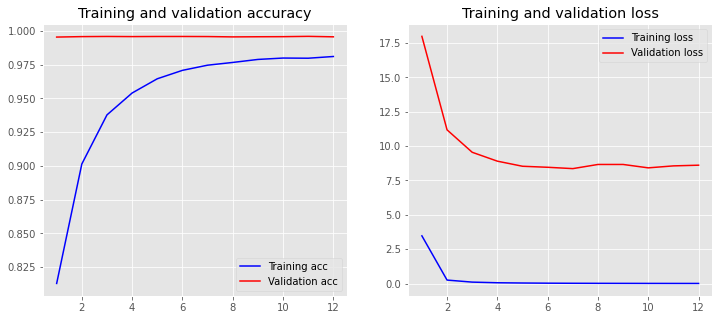

864/864 [==============================] - 66s 73ms/step
F1-score: 68.4%
Classification Report:
,precision,recall,f1-score,support
problem,0.6463207616798288,0.6977133296151701,0.6710344827586207,12551.0
test,0.7588583867456766,0.6962938304482912,0.7262311208842082,9012.0
treatment,0.687434978615189,0.6382955887088119,0.6619545859305432,9317.0
micro avg,0.6885358889362959,0.679371761658031,0.68392312833135,30880.0
macro avg,0.6975380423468982,0.6774342495907577,0.6864067298577906,30880.0
weighted avg,0.6915685024920105,0.679371761658031,0.6844034822418006,30880.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4334
Points in y_train after augmentation: 4334
Converted 10425 words (18091 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 204, 100)          2851600   
                                                                 
 bidirectional_8 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,013,856
Trainable params: 3,013,856
Non-trainab

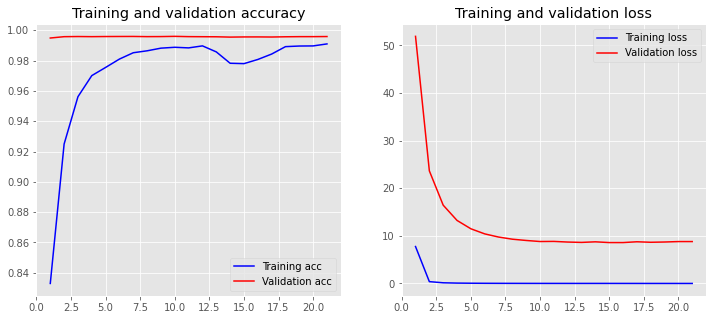

864/864 [==============================] - 65s 72ms/step
F1-score: 65.4%
Classification Report:
,precision,recall,f1-score,support
problem,0.6337604198826798,0.6542108198549916,0.6438232642019838,12551.0
test,0.6939957669600089,0.691300488237905,0.6926455055867475,9012.0
treatment,0.6879468845760981,0.5782977353225287,0.6283748323517406,9317.0
micro avg,0.6661851167478582,0.6421308290155441,0.6539368455767169,30880.0
macro avg,0.6719010238062623,0.6412696811384752,0.6549478673801573,30880.0
weighted avg,0.6676884069101884,0.6421308290155441,0.6534104727450789,30880.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4334
Points in y_train after augmentation: 4334
Converted 10403 words (18073 misses)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 204, 100)          2847600   
                                                                 
 bidirectional_9 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_9 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,009,856
Trainable params: 3,009,856
Non-trainab

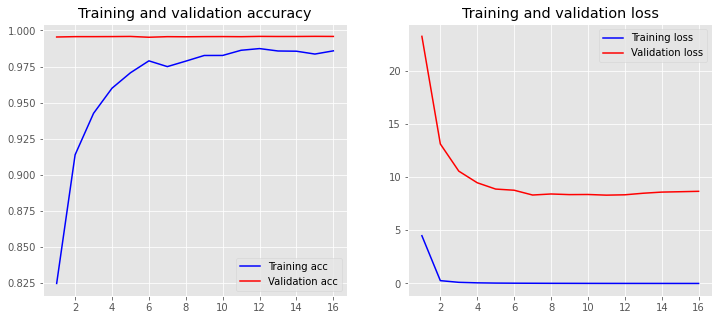

864/864 [==============================] - 66s 73ms/step
F1-score: 66.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.6771520378826315,0.6380368098159509,0.6570127579275546,12551.0
test,0.7091514143094841,0.7093874833555259,0.7092694291895488,9012.0
treatment,0.6650491045638359,0.6177954277127831,0.6405519697306922,9317.0
micro avg,0.6833807973962571,0.6527525906735752,0.6677156486020935,30880.0
macro avg,0.6837841855853172,0.6550732402947533,0.6689447189492652,30880.0
weighted avg,0.6828390634858561,0.6527525906735752,0.6672968239179342,30880.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5201
Points in y_train after augmentation: 5201
Converted 10464 words (18111 misses)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 204, 100)          2857500   
                                                                 
 bidirectional_10 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_10 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,019,756
Trainable params: 3,019,756
Non-traina

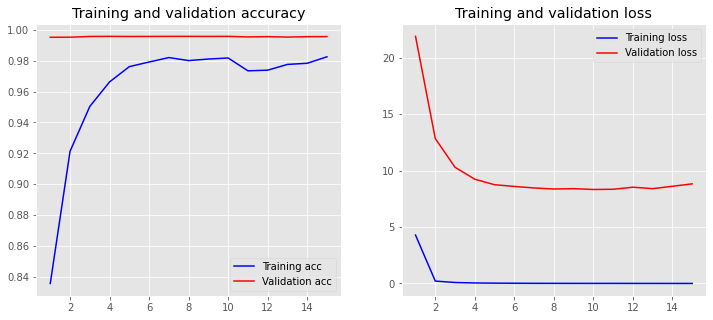

864/864 [==============================] - 64s 71ms/step
F1-score: 67.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.6442947883982552,0.6707832045255359,0.6572722304629558,12551.0
test,0.7491128459900639,0.7027296937416777,0.7251803503950532,9012.0
treatment,0.6396861449514764,0.6650209294837394,0.6521075619639004,9317.0
micro avg,0.6712596532829173,0.6783678756476684,0.6747950456617327,30880.0
macro avg,0.6776979264465984,0.6795112759169842,0.6781867142739698,30880.0
weighted avg,0.6734943222073141,0.6783678756476684,0.6755322291812965,30880.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5201
Points in y_train after augmentation: 5201
Converted 10492 words (18104 misses)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 204, 100)          2859600   
                                                                 
 bidirectional_11 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_11 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,021,856
Trainable params: 3,021,856
Non-traina

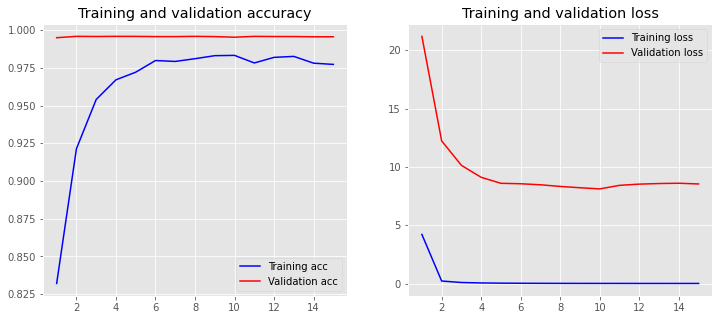

864/864 [==============================] - 65s 72ms/step
F1-score: 63.1%
Classification Report:
,precision,recall,f1-score,support
problem,0.5545904133908192,0.6969165803521632,0.6176605585566501,12551.0
test,0.6729619137551149,0.7117177097203728,0.6917974437793237,9012.0
treatment,0.5682758620689655,0.6190833959429001,0.5925925925925927,9317.0
micro avg,0.5903308605759738,0.6777525906735752,0.6310282966246061,30880.0
macro avg,0.5986093964049665,0.6759058953384787,0.6340168649761888,30880.0
weighted avg,0.5932650016880122,0.6777525906735752,0.6317332065728293,30880.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5201
Points in y_train after augmentation: 5201
Converted 10471 words (18119 misses)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 204, 100)          2859000   
                                                                 
 bidirectional_12 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_12 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_12 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,021,256
Trainable params: 3,021,256
Non-traina

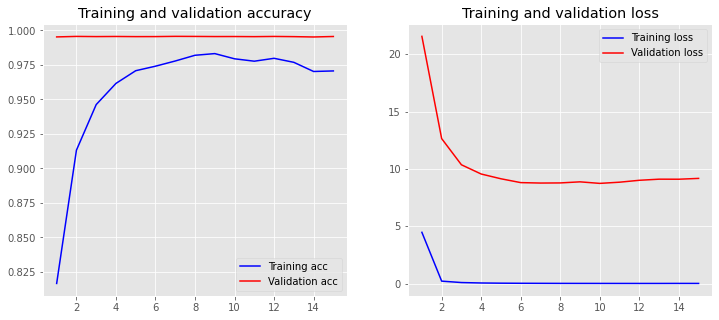

864/864 [==============================] - 64s 70ms/step
F1-score: 65.9%
Classification Report:
,precision,recall,f1-score,support
problem,0.6458349876915747,0.6479961756035376,0.6469137766465161,12551.0
test,0.7308573495719282,0.6725477141588992,0.7004911875180583,9012.0
treatment,0.6277060782681099,0.6473113663196308,0.6373579920739761,9317.0
micro avg,0.6632452285695547,0.6549546632124352,0.6590738749307524,30880.0
macro avg,0.6681328051772043,0.6559517520273559,0.6615876520795169,30880.0
weighted avg,0.6651780730596876,0.6549546632124352,0.6596666387550648,30880.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5201
Points in y_train after augmentation: 5201
Converted 10480 words (18110 misses)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 204, 100)          2859000   
                                                                 
 bidirectional_13 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_13 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_13 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,021,256
Trainable params: 3,021,256
Non-traina

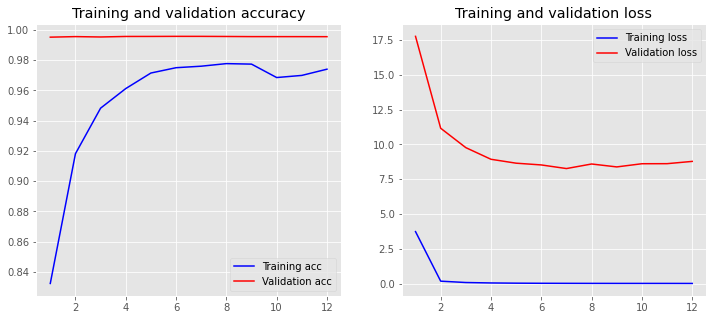

864/864 [==============================] - 66s 74ms/step
F1-score: 66.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.6126870990734141,0.6848856664807585,0.6467777735976826,12551.0
test,0.666766706682673,0.7395694629383045,0.7012836700336701,9012.0
treatment,0.6575208762607092,0.6507459482666095,0.65411587010465,9317.0
micro avg,0.6413811772490751,0.6905440414507772,0.6650552809269107,30880.0
macro avg,0.6456582273389321,0.6917336925618908,0.6673924379120009,30880.0
weighted avg,0.6419967404538763,0.6905440414507772,0.6648987640068968,30880.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5201
Points in y_train after augmentation: 5201
Converted 10469 words (18113 misses)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 204, 100)          2858200   
                                                                 
 bidirectional_14 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_14 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_14 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,020,456
Trainable params: 3,020,456
Non-traina

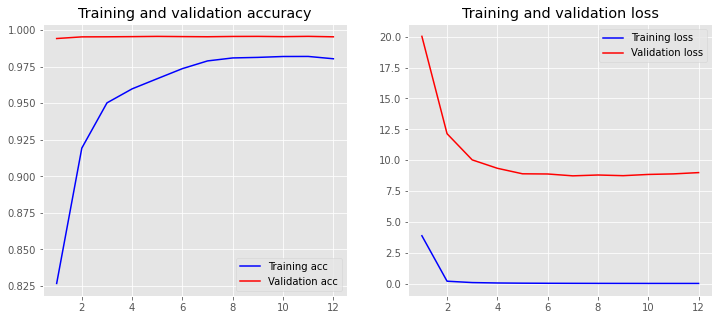

864/864 [==============================] - 64s 71ms/step
F1-score: 66.2%
Classification Report:
,precision,recall,f1-score,support
problem,0.6050684831172636,0.6581945661700263,0.6305144252785834,12551.0
test,0.7259620974305313,0.6928539724811362,0.7090217453017656,9012.0
treatment,0.6804908533121237,0.6428034775142213,0.6611104978474445,9317.0
micro avg,0.6599259378521977,0.6636658031088083,0.6617905869056269,30880.0
macro avg,0.670507144619973,0.6646173387217945,0.6668822228092646,30880.0
weighted avg,0.6631061604260939,0.6636658031088083,0.662657287201284,30880.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5201
Points in y_train after augmentation: 5201
Converted 10472 words (18105 misses)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 204, 100)          2857700   
                                                                 
 bidirectional_15 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_15 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_15 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,019,956
Trainable params: 3,019,956
Non-traina

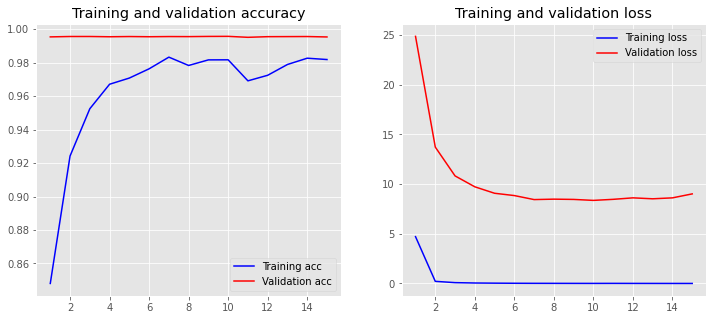

864/864 [==============================] - 65s 72ms/step
F1-score: 66.4%
Classification Report:
,precision,recall,f1-score,support
problem,0.6412453147709019,0.6679149071787108,0.654308460817983,12551.0
test,0.690589765828274,0.7068353306702175,0.6986181180083352,9012.0
treatment,0.6379837604133713,0.6493506493506493,0.6436170212765958,9317.0
micro avg,0.6545940843297672,0.6736722797927461,0.6639961698052985,30880.0
macro avg,0.6566062803375158,0.6747002957331926,0.665514533367638,30880.0
weighted avg,0.6546619045047077,0.6736722797927461,0.6640139818151446,30880.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5201
Points in y_train after augmentation: 5201
Converted 10476 words (18118 misses)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 204, 100)          2859400   
                                                                 
 bidirectional_16 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_16 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_16 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,021,656
Trainable params: 3,021,656
Non-traina

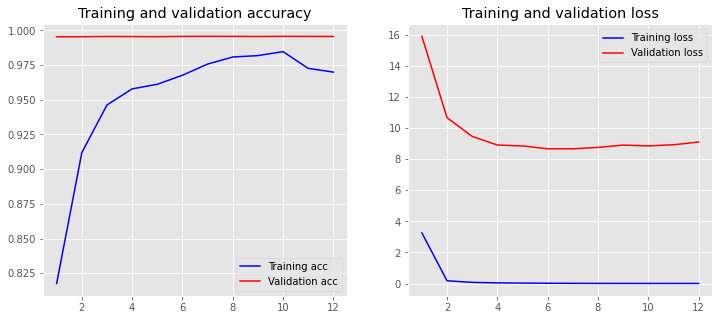

864/864 [==============================] - 64s 71ms/step
F1-score: 67.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.6777319066475693,0.6409051071627758,0.6588042588042587,12551.0
test,0.7639563106796117,0.6985130936529073,0.7297704613957803,9012.0
treatment,0.7129992169146437,0.5863475367607599,0.6435007950998292,9317.0
micro avg,0.7130459832199056,0.6412564766839378,0.6752485038618267,30880.0
macro avg,0.718229144747275,0.6419219125254809,0.677358505099956,30880.0
weighted avg,0.7135363062231878,0.6412564766839378,0.6748976864733203,30880.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5201
Points in y_train after augmentation: 5201
Converted 10471 words (18117 misses)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 204, 100)          2858800   
                                                                 
 bidirectional_17 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_17 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_17 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,021,056
Trainable params: 3,021,056
Non-traina

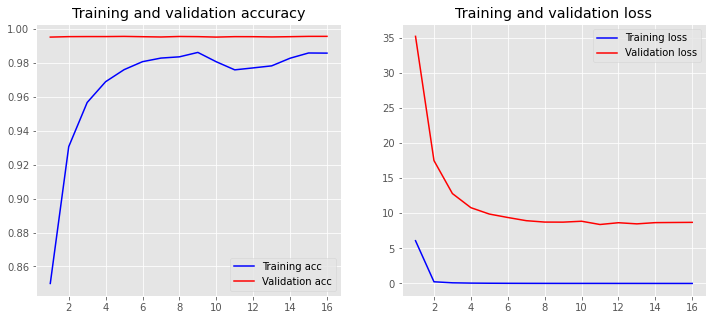

864/864 [==============================] - 65s 72ms/step
F1-score: 65.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.6272850883819308,0.6616205880009561,0.6439955019581993,12551.0
test,0.6771627444481273,0.6800932090545939,0.6786248131539612,9012.0
treatment,0.6197967559116669,0.6807985403026725,0.6488670656232417,9317.0
micro avg,0.6388094579220859,0.6727979274611399,0.655363310884343,30880.0
macro avg,0.6414148629139084,0.6741707791194075,0.657162460245134,30880.0
weighted avg,0.639582000391099,0.6727979274611399,0.6555715288741127,30880.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5201
Points in y_train after augmentation: 5201
Converted 10476 words (18118 misses)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 204, 100)          2859400   
                                                                 
 bidirectional_18 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_18 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_18 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,021,656
Trainable params: 3,021,656
Non-traina

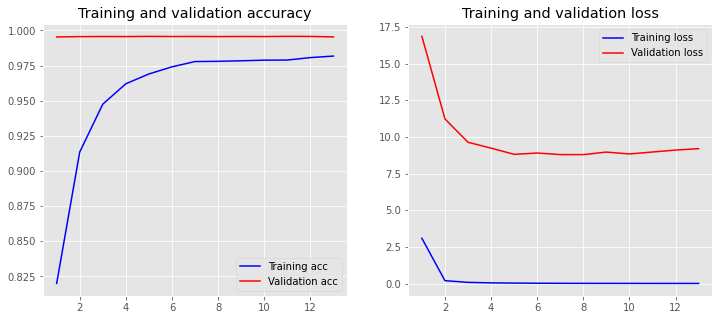

864/864 [==============================] - 65s 72ms/step
F1-score: 66.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.614068580659373,0.666321408652697,0.6391287734046618,12551.0
test,0.6967572304995618,0.7057256990679095,0.701212789415656,9012.0
treatment,0.6677269112802454,0.6308897713856392,0.6487858719646798,9317.0
micro avg,0.6529635499207607,0.667130829015544,0.6599711677078327,30880.0
macro avg,0.6595175741463933,0.6676456263687486,0.6630424782616658,30880.0
weighted avg,0.6543899789351001,0.667130829015544,0.6601610382872644,30880.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 5201
Points in y_train after augmentation: 5201
Converted 10462 words (18124 misses)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 204, 100)          2858600   
                                                                 
 bidirectional_19 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_19 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_19 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,020,856
Trainable params: 3,020,856
Non-traina

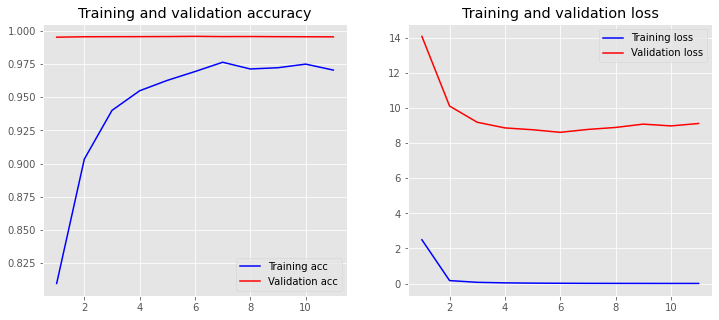

864/864 [==============================] - 66s 73ms/step
F1-score: 68.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.679016366745379,0.6644092104214804,0.6716333762886597,12551.0
test,0.7409186782282634,0.7016200621393698,0.720734070443406,9012.0
treatment,0.6759654178674351,0.629387141783836,0.6518452645620276,9317.0
micro avg,0.6960325534079349,0.6647020725388602,0.6800066258075202,30880.0
macro avg,0.6986334876136925,0.6651388047815621,0.6814042370980311,30880.0
weighted avg,0.6961613777683049,0.6647020725388602,0.6799924960673365,30880.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6068
Points in y_train after augmentation: 6068
Converted 10515 words (18133 misses)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 204, 100)          2864800   
                                                                 
 bidirectional_20 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_20 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_20 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,027,056
Trainable params: 3,027,056
Non-traina

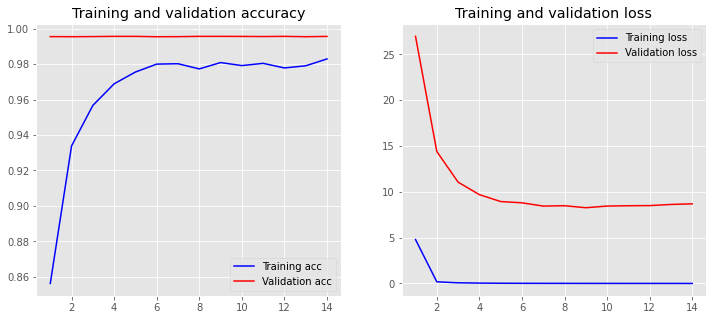

864/864 [==============================] - 66s 73ms/step
F1-score: 65.1%
Classification Report:
,precision,recall,f1-score,support
problem,0.62548435171386,0.6687913313680185,0.646413307150283,12551.0
test,0.6762083012220632,0.6815357301375943,0.678861563967947,9012.0
treatment,0.6304464190129536,0.6320704089299131,0.6312573694929788,9317.0
micro avg,0.6414081145584726,0.6614313471502591,0.6512658631464829,30880.0
macro avg,0.6440463573162923,0.660799156811842,0.6521774135370696,30880.0
weighted avg,0.6417847342913724,0.6614313471502591,0.6513101924899101,30880.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6068
Points in y_train after augmentation: 6068
Converted 10528 words (18125 misses)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 204, 100)          2865300   
                                                                 
 bidirectional_21 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_21 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_21 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,027,556
Trainable params: 3,027,556
Non-traina

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6068
Points in y_train after augmentation: 6068
Converted 10536 words (18140 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 204, 100)          2867600   
                                                                 
 bidirectional (Bidirectiona  (None, 204, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 204, 7)           1407      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 204, 7)            49        
                                                                 
Total params: 3,029,856
Trainable params: 3,029,856
Non-trainable

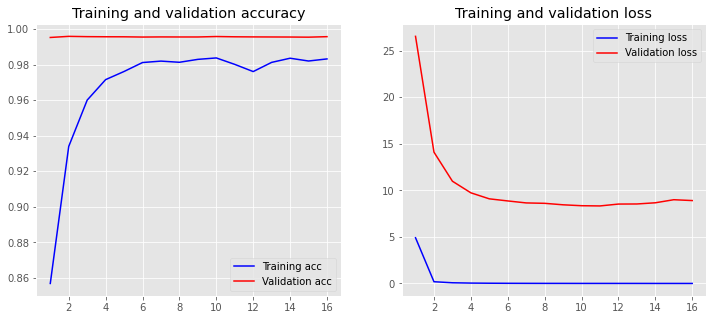

864/864 [==============================] - 64s 71ms/step
F1-score: 64.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.6076463207616798,0.6559636682336069,0.6308812260536398,12551.0
test,0.6328853134504071,0.7158233466489126,0.6718042176516532,9012.0
treatment,0.6066481994459834,0.6346463453901471,0.6203315148971885,9317.0
micro avg,0.6150377735973006,0.6670012953367875,0.6399664434743432,30880.0
macro avg,0.6157266112193568,0.6688111200908889,0.6410056528674938,30880.0
weighted avg,0.6147109032037934,0.6670012953367875,0.6396411464369507,30880.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6068
Points in y_train after augmentation: 6068
Converted 10513 words (18124 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 204, 100)          2863700   
                                                                 
 bidirectional_1 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,025,956
Trainable params: 3,025,956
Non-trainab

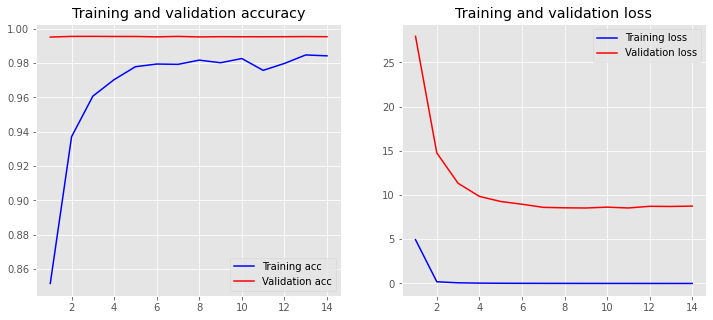

864/864 [==============================] - 69s 76ms/step
F1-score: 65.9%
Classification Report:
,precision,recall,f1-score,support
problem,0.6683960604994724,0.6056091148115688,0.6354554194708022,12551.0
test,0.7352119236143456,0.7006213936972925,0.7175,9012.0
treatment,0.662687265917603,0.6077063432435333,0.6340070544762331,9317.0
micro avg,0.6868158854897558,0.633970207253886,0.6593358480398761,30880.0
macro avg,0.688765083343807,0.6379789505841315,0.6623208246490118,30880.0
weighted avg,0.6861731239473985,0.633970207253886,0.6589622634822896,30880.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6068
Points in y_train after augmentation: 6068
Converted 10518 words (18136 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 204, 100)          2865400   
                                                                 
 bidirectional_2 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,027,656
Trainable params: 3,027,656
Non-trainab

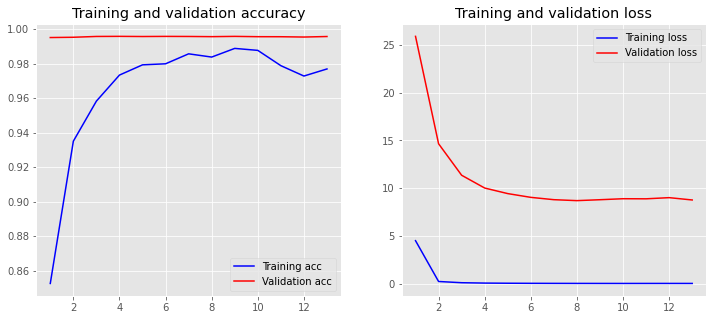

864/864 [==============================] - 66s 73ms/step
F1-score: 66.1%
Classification Report:
,precision,recall,f1-score,support
problem,0.6461833893422948,0.643454704804398,0.6448161603257615,12551.0
test,0.6619306731156792,0.7289169995561473,0.6938107308829742,9012.0
treatment,0.6317758899676376,0.6704947944617367,0.6505597500650874,9317.0
micro avg,0.64661095636026,0.6765544041450777,0.6612438677005855,30880.0
macro avg,0.6466299841418706,0.6809554996074273,0.663062213757941,30880.0
weighted avg,0.6464320891380221,0.6765544041450777,0.6608476401011144,30880.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6068
Points in y_train after augmentation: 6068
Converted 10509 words (18146 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 204, 100)          2865500   
                                                                 
 bidirectional_3 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,027,756
Trainable params: 3,027,756
Non-trainab

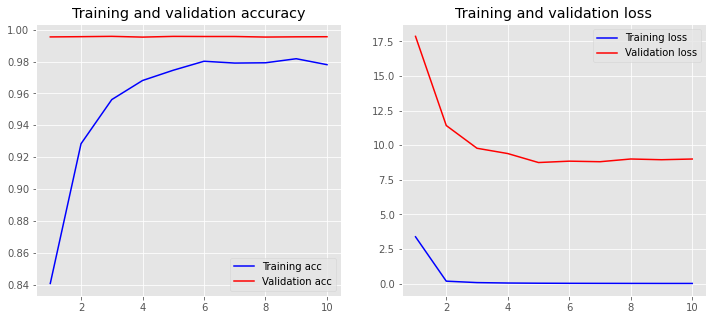

864/864 [==============================] - 67s 74ms/step
F1-score: 66.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.6491725768321513,0.6563620428651104,0.6527475139653738,12551.0
test,0.7348961978073245,0.699178872614292,0.7165927442283635,9012.0
treatment,0.6504332565536909,0.6364709670494795,0.643376369751546,9317.0
micro avg,0.6737434580823541,0.6628562176165803,0.6682554969719724,30880.0
macro avg,0.6781673437310555,0.6640039608429606,0.6709055426484278,30880.0
weighted avg,0.6745704727257343,0.6628562176165803,0.6685526391107698,30880.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6068
Points in y_train after augmentation: 6068
Converted 10519 words (18136 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 204, 100)          2865500   
                                                                 
 bidirectional_4 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,027,756
Trainable params: 3,027,756
Non-trainab

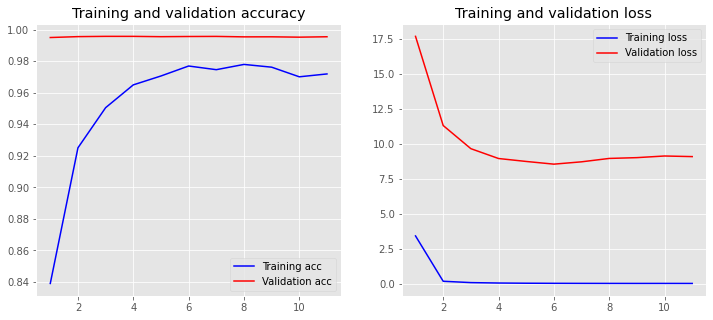

864/864 [==============================] - 65s 71ms/step
F1-score: 65.4%
Classification Report:
,precision,recall,f1-score,support
problem,0.5911758613546917,0.682176718986535,0.6334245764592735,12551.0
test,0.7118091913903433,0.678872614292055,0.6949508718123474,9012.0
treatment,0.6722365038560412,0.6174734356552538,0.6436923076923077,9317.0
micro avg,0.645878113541535,0.661690414507772,0.6536886557041397,30880.0
macro avg,0.658407185533692,0.6595075896446146,0.6573559186546429,30880.0
weighted avg,0.6508387362402606,0.661690414507772,0.6544783143355715,30880.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6068
Points in y_train after augmentation: 6068
Converted 10524 words (18132 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 204, 100)          2865600   
                                                                 
 bidirectional_5 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,027,856
Trainable params: 3,027,856
Non-trainab

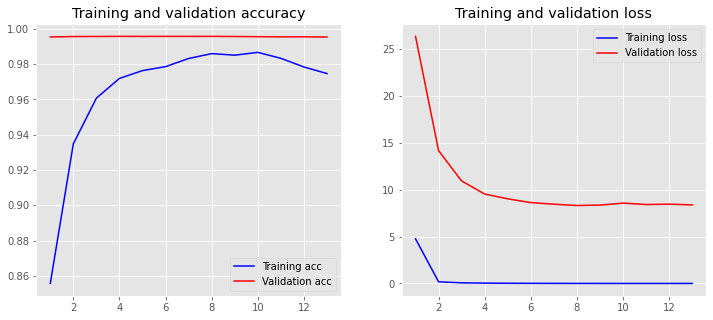

864/864 [==============================] - 66s 72ms/step
F1-score: 67.3%
Classification Report:
,precision,recall,f1-score,support
problem,0.6432856483617905,0.6664010835789977,0.6546393769811765,12551.0
test,0.7267146735922559,0.6830892143808256,0.704226963335812,9012.0
treatment,0.7177210506844247,0.6246645916067404,0.6679674050269712,9317.0
micro avg,0.6875802853086336,0.658678756476684,0.6728192914557903,30880.0
macro avg,0.6959071242128237,0.6580516298555212,0.6756112484479866,30880.0
weighted avg,0.6900918989711472,0.658678756476684,0.673132270942661,30880.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6068
Points in y_train after augmentation: 6068
Converted 10514 words (18129 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 204, 100)          2864300   
                                                                 
 bidirectional_6 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,026,556
Trainable params: 3,026,556
Non-trainab

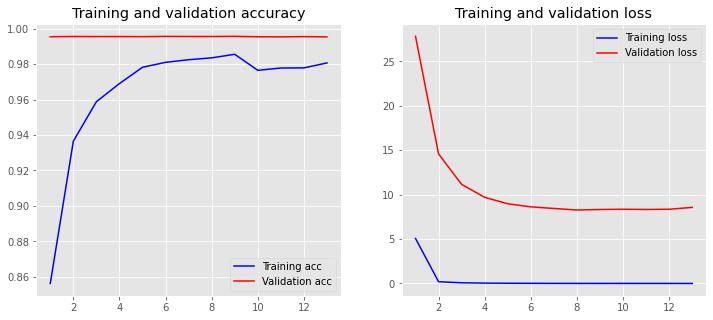

864/864 [==============================] - 67s 74ms/step
F1-score: 66.3%
Classification Report:
,precision,recall,f1-score,support
problem,0.6416398335034948,0.6509441478766632,0.6462585034013605,12551.0
test,0.7159858107334935,0.6942964935641367,0.7049743676412596,9012.0
treatment,0.6643578971272851,0.6279918428678759,0.6456632090046348,9317.0
micro avg,0.6697050761253674,0.6566709844559585,0.6631239882928105,30880.0
macro avg,0.6739945137880912,0.6577441614362253,0.6656320266824184,30880.0
weighted avg,0.6701913278551659,0.6566709844559585,0.6632144946784226,30880.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6068
Points in y_train after augmentation: 6068
Converted 10527 words (18129 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 204, 100)          2865600   
                                                                 
 bidirectional_7 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,027,856
Trainable params: 3,027,856
Non-trainab

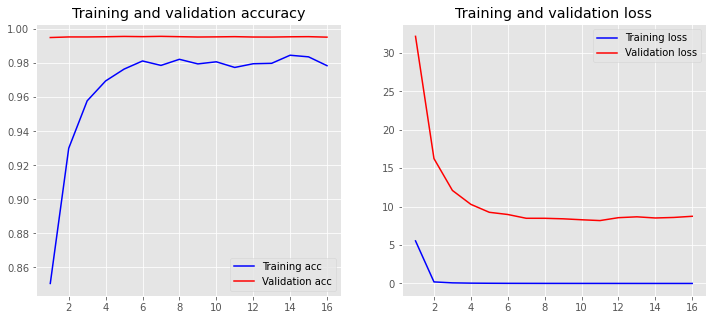

864/864 [==============================] - 68s 76ms/step
F1-score: 65.9%
Classification Report:
,precision,recall,f1-score,support
problem,0.6392444101773324,0.6605848139590471,0.6497394302731084,12551.0
test,0.7201432201432202,0.691855304039059,0.7057159026598755,9012.0
treatment,0.6337336244541485,0.6230546313190941,0.628348757915246,9317.0
micro avg,0.6603546836429778,0.6583873056994819,0.659369527145359,30880.0
macro avg,0.664373751591567,0.6584982497724,0.6612680302827433,30880.0
weighted avg,0.6611911745824385,0.6583873056994819,0.6596216541976985,30880.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6068
Points in y_train after augmentation: 6068
Converted 10516 words (18135 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 204, 100)          2865100   
                                                                 
 bidirectional_8 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,027,356
Trainable params: 3,027,356
Non-trainab

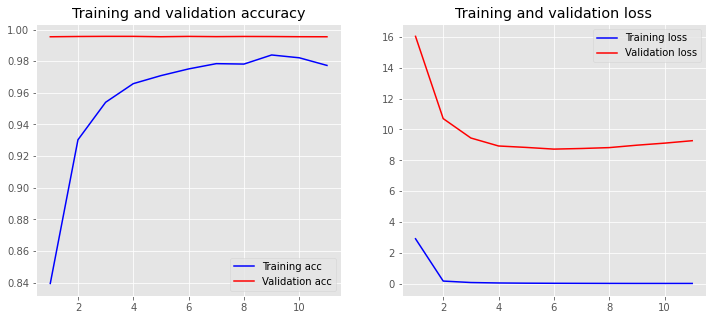

864/864 [==============================] - 65s 72ms/step
F1-score: 65.7%
Classification Report:
,precision,recall,f1-score,support
problem,0.6610400682011935,0.6177993785355749,0.6386886866274041,12551.0
test,0.6803522172713771,0.711606746560142,0.6956285931228984,9012.0
treatment,0.672878574777309,0.6161854674251368,0.64328533811418,9317.0
micro avg,0.6705739692805174,0.6446891191709845,0.6573768326509047,30880.0
macro avg,0.6714236200832931,0.6485305308402846,0.6592008726214941,30880.0
weighted avg,0.6702479844314448,0.6446891191709845,0.6566928783126271,30880.0



In [13]:
number_of_training_models = 9
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Converted 10551 words (18140 misses)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 204, 100)          2869100   
                                                                 
 bidirectional_9 (Bidirectio  (None, 204, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 204, 7)           1407      
 tributed)                                                       
                                                                 
 crf_9 (CRF)                 (None, 204, 7)            49        
                                                                 
Total params: 3,031,356
Trainable params: 3,031,356
Non-trainab

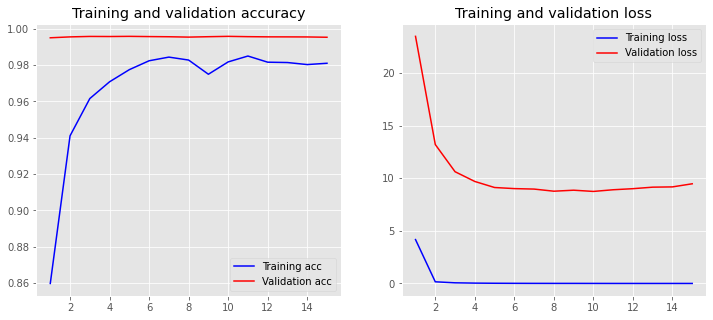

864/864 [==============================] - 65s 71ms/step
F1-score: 65.4%
Classification Report:
,precision,recall,f1-score,support
problem,0.6458873056994818,0.6356465620269302,0.6407260169457494,12551.0
test,0.7162020296279016,0.6813138038171327,0.6983224338925221,9012.0
treatment,0.6663068249970013,0.5962219598583235,0.6293191344737736,9317.0
micro avg,0.6723053789898161,0.6370790155440414,0.6542183499052242,30880.0
macro avg,0.6761320534414615,0.6377274419007954,0.6561225284373484,30880.0
weighted avg,0.6725688132557611,0.6370790155440414,0.6540932768399501,30880.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Converted 10557 words (18141 misses)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 204, 100)          2869800   
                                                                 
 bidirectional_10 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_10 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,032,056
Trainable params: 3,032,056
Non-traina

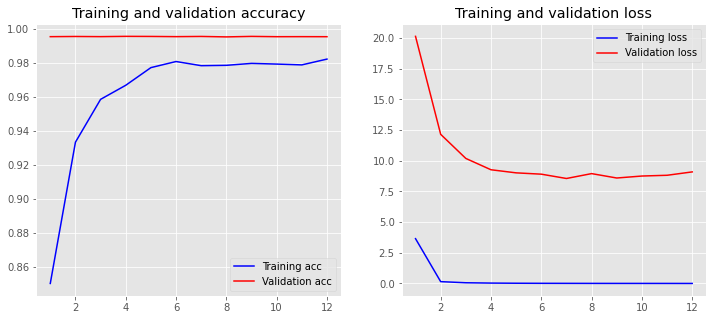

864/864 [==============================] - 64s 71ms/step
F1-score: 64.2%
Classification Report:
,precision,recall,f1-score,support
problem,0.6270754498416866,0.6469604015616286,0.6368627450980392,12551.0
test,0.7191874148395887,0.6442521083000444,0.6796605209247879,9012.0
treatment,0.5777505189658426,0.6571857894171944,0.6149133818729601,9317.0
micro avg,0.6340607210626186,0.6492551813471502,0.641568,30880.0
macro avg,0.6413377945490394,0.6494660997596226,0.6438122159652623,30880.0
weighted avg,0.6390752117455355,0.6492551813471502,0.6427303402593927,30880.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Converted 10551 words (18139 misses)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 204, 100)          2869000   
                                                                 
 bidirectional_11 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_11 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,031,256
Trainable params: 3,031,256
Non-traina

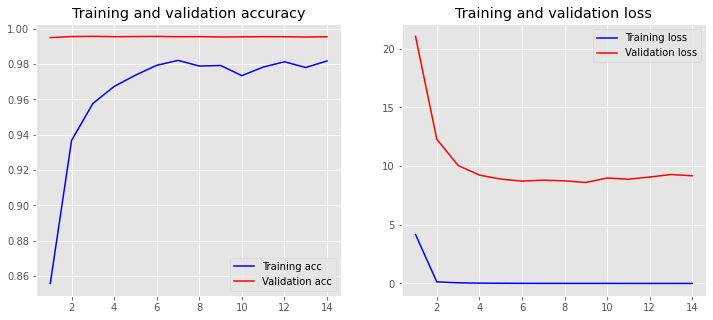

864/864 [==============================] - 68s 75ms/step
F1-score: 63.7%
Classification Report:
,precision,recall,f1-score,support
problem,0.6259483485324546,0.6507847980240619,0.6381250000000002,12551.0
test,0.6174607814479197,0.703173546382601,0.6575356679636836,9012.0
treatment,0.6066757350633044,0.6223033165181926,0.61439016636643,9317.0
micro avg,0.6176944841644102,0.6574805699481865,0.6369668543820295,30880.0
macro avg,0.6166949550145596,0.6587538869749517,0.6366836114433713,30880.0
weighted avg,0.6176564801950873,0.6574805699481865,0.6366286105804646,30880.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Converted 10565 words (18142 misses)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 204, 100)          2870700   
                                                                 
 bidirectional_12 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_12 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_12 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,032,956
Trainable params: 3,032,956
Non-traina

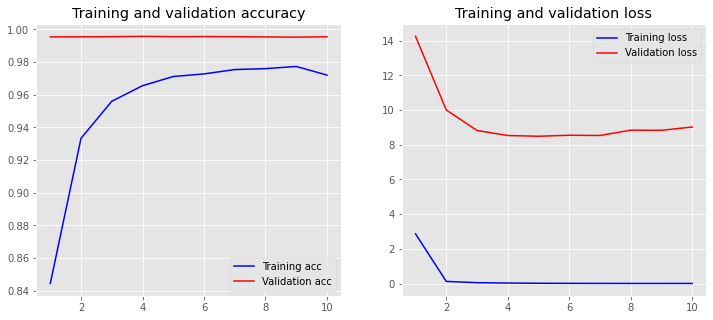

864/864 [==============================] - 67s 74ms/step
F1-score: 65.2%
Classification Report:
,precision,recall,f1-score,support
problem,0.66095043085061,0.61724165405147,0.6383487145682267,12551.0
test,0.7259615384615384,0.653462050599201,0.6878065872459707,9012.0
treatment,0.6978233034571063,0.5849522378447999,0.6364220237052607,9317.0
micro avg,0.6904460442064899,0.6180699481865285,0.6522563778343559,30880.0
macro avg,0.6949117575897515,0.6185519808318237,0.6541924418398194,30880.0
weighted avg,0.6910483795508824,0.6180699481865285,0.6522011553001429,30880.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Converted 10549 words (18163 misses)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 204, 100)          2871200   
                                                                 
 bidirectional_13 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_13 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_13 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,033,456
Trainable params: 3,033,456
Non-traina

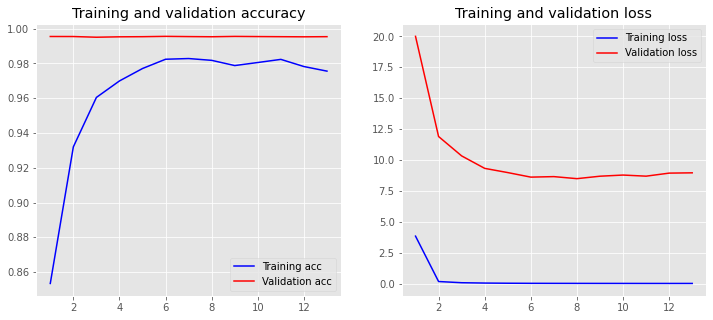

864/864 [==============================] - 69s 76ms/step
F1-score: 65.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.5862408553742262,0.6640108357899769,0.6227070646691821,12551.0
test,0.7165227403569372,0.6905237461162894,0.7032830423235577,9012.0
treatment,0.6565266742338252,0.6208006869163893,0.6381640646549346,9317.0
micro avg,0.6414493393459683,0.6587111398963731,0.6499656500135802,30880.0
macro avg,0.6530967566549962,0.6584450896075519,0.6547180572158915,30880.0
weighted avg,0.6454686183852066,0.6587111398963731,0.6508859370619441,30880.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Converted 10538 words (18145 misses)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 204, 100)          2868300   
                                                                 
 bidirectional_14 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_14 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_14 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,030,556
Trainable params: 3,030,556
Non-traina

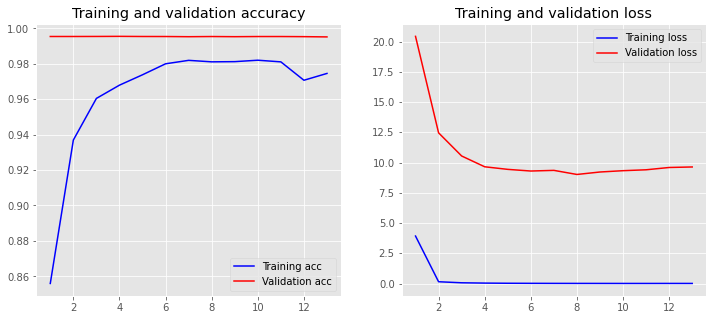

864/864 [==============================] - 67s 75ms/step
F1-score: 63.9%
Classification Report:
,precision,recall,f1-score,support
problem,0.6117729502452698,0.6260058959445463,0.6188075923446483,12551.0
test,0.6619762679827785,0.6995117620949844,0.6802265983274886,9012.0
treatment,0.6672344567465628,0.5886014811634647,0.6254562043795621,9317.0
micro avg,0.6423083210724211,0.6361722797927462,0.6392255755307898,30880.0
macro avg,0.6469945583248703,0.638039713067665,0.6414967983505663,30880.0
weighted avg,0.6431578969914801,0.6361722797927462,0.6387380716272469,30880.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Converted 10551 words (18149 misses)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 204, 100)          2870000   
                                                                 
 bidirectional_15 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_15 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_15 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,032,256
Trainable params: 3,032,256
Non-traina

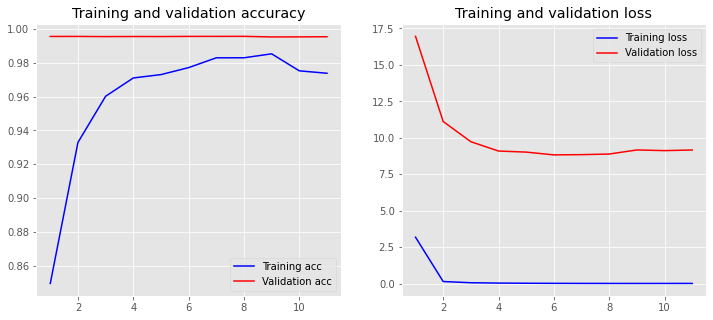

864/864 [==============================] - 71s 78ms/step
F1-score: 65.9%
Classification Report:
,precision,recall,f1-score,support
problem,0.6367406684557209,0.6238546729344275,0.630231809401159,12551.0
test,0.719616569667922,0.699733688415446,0.7095358649789029,9012.0
treatment,0.6844926155312053,0.6168294515401953,0.6489019364308699,9317.0
micro avg,0.6750067897881586,0.6438795336787565,0.6590758419517371,30880.0
macro avg,0.6802832845516161,0.6468059376300229,0.6628898702703105,30880.0
weighted avg,0.6753346617402625,0.6438795336787565,0.6590089377173003,30880.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Converted 10546 words (18137 misses)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 204, 100)          2868300   
                                                                 
 bidirectional_16 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_16 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_16 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,030,556
Trainable params: 3,030,556
Non-traina

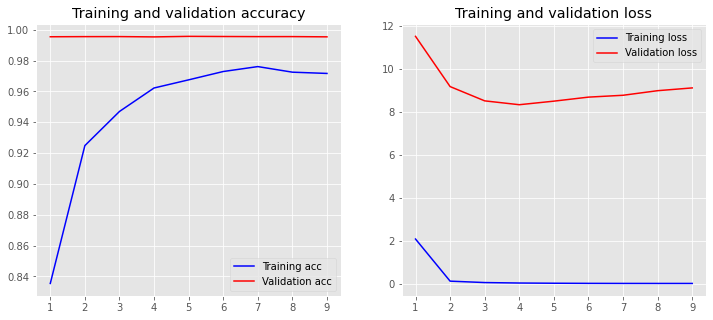

864/864 [==============================] - 68s 74ms/step
F1-score: 64.6%
Classification Report:
,precision,recall,f1-score,support
problem,0.6449438202247191,0.6174010039040714,0.6308719368232516,12551.0
test,0.6584484590860786,0.6875277407900577,0.6726739767669091,9012.0
treatment,0.6598787324104793,0.6190833959429001,0.6388304352641488,9317.0
micro avg,0.6534840548962408,0.6383743523316062,0.6458408413327655,30880.0
macro avg,0.654423670573759,0.6413373802123431,0.6474587829514364,30880.0
weighted avg,0.6533911123961342,0.6383743523316062,0.6454726270417128,30880.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Converted 10537 words (18146 misses)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 204, 100)          2868300   
                                                                 
 bidirectional_17 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_17 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_17 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,030,556
Trainable params: 3,030,556
Non-traina

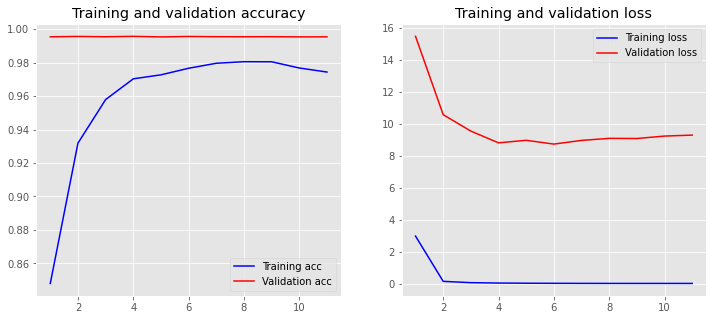

864/864 [==============================] - 69s 76ms/step
F1-score: 67.1%
Classification Report:
,precision,recall,f1-score,support
problem,0.6588792549775209,0.6538921201497888,0.6563762146598952,12551.0
test,0.7518658999143522,0.6818686196182867,0.7151585685190572,9012.0
treatment,0.6910608443207935,0.6131802082215305,0.6497952684258417,9317.0
micro avg,0.6943867663344407,0.6497733160621761,0.6713396680942184,30880.0
macro avg,0.7006019997375555,0.649646982663202,0.6737766838682647,30880.0
weighted avg,0.6957261303687772,0.6497733160621761,0.6715456413734991,30880.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 6934
Points in y_train after augmentation: 6934
Converted 10551 words (18153 misses)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 204, 100)          2870400   
                                                                 
 bidirectional_18 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_18 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_18 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,032,656
Trainable params: 3,032,656
Non-traina

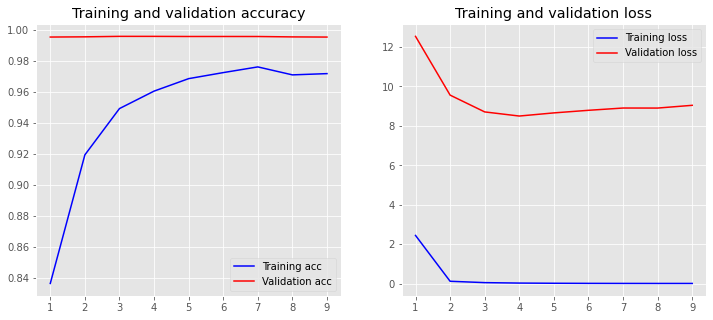

864/864 [==============================] - 70s 77ms/step
F1-score: 66.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.6420299992228181,0.6581945661700263,0.6500118026595326,12551.0
test,0.7611048898842852,0.6787616511318242,0.7175787436213267,9012.0
treatment,0.6637900874635568,0.6109262638188258,0.6362620165437066,9317.0
micro avg,0.6808236371654398,0.6499352331606217,0.6650209579350221,30880.0
macro avg,0.6889749921902201,0.6492941603735588,0.6679508542748552,30880.0
weighted avg,0.6833461150511893,0.6499352331606217,0.665581961814537,30880.0



In [14]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Converted 10713 words (18209 misses)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 204, 100)          2892200   
                                                                 
 bidirectional_19 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_19 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_19 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,054,456
Trainable params: 3,054,456
Non-trai

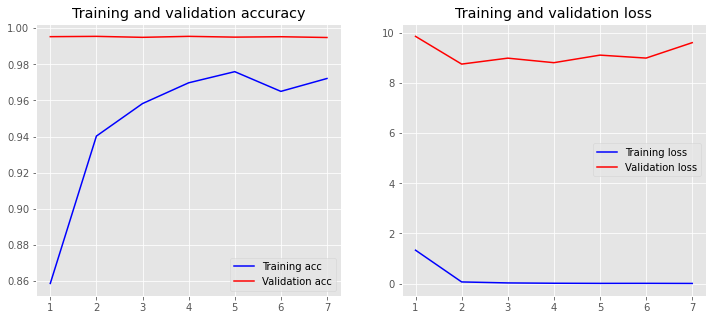

864/864 [==============================] - 68s 75ms/step
F1-score: 64.4%
Classification Report:
,precision,recall,f1-score,support
problem,0.6669916681439461,0.5995538204127161,0.6314773633197668,12551.0
test,0.727876388711531,0.6324900133155792,0.6768390429258445,9012.0
treatment,0.7034235668789809,0.5689599656541805,0.629086809470124,9317.0
micro avg,0.6951855604337874,0.5999352331606218,0.6440577795546595,30880.0
macro avg,0.6994305412448193,0.6003345997941586,0.645801071905245,30880.0
weighted avg,0.6957523256008565,0.5999352331606218,0.6439944185786025,30880.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Converted 10693 words (18217 misses)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 204, 100)          2891000   
                                                                 
 bidirectional_20 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_20 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_20 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,053,256
Trainable params: 3,053,256
Non-trai

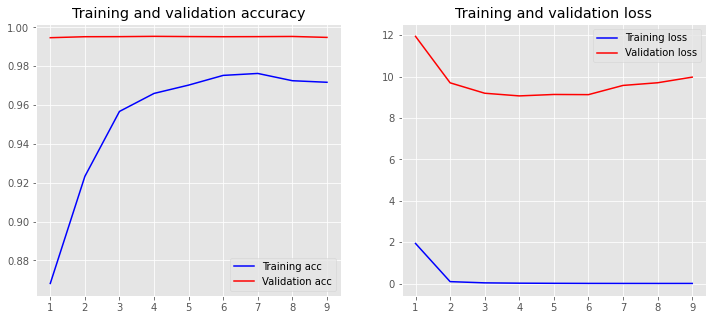

864/864 [==============================] - 68s 75ms/step
F1-score: 63.4%
Classification Report:
,precision,recall,f1-score,support
problem,0.6363245289512174,0.5892757549199267,0.6118970795069083,12551.0
test,0.7304795380366558,0.6456946293830448,0.6854753210036518,9012.0
treatment,0.6222903437705277,0.6100676183320811,0.6161183675681534,9317.0
micro avg,0.6579744455662709,0.6120142487046633,0.6341627099307082,30880.0
macro avg,0.6630314702528003,0.6150126675450175,0.6378302560262378,30880.0
weighted avg,0.659568325536369,0.6120142487046633,0.6346437392619366,30880.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Converted 10678 words (18208 misses)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 204, 100)          2888600   
                                                                 
 bidirectional_21 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_21 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_21 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,050,856
Trainable params: 3,050,856
Non-trai

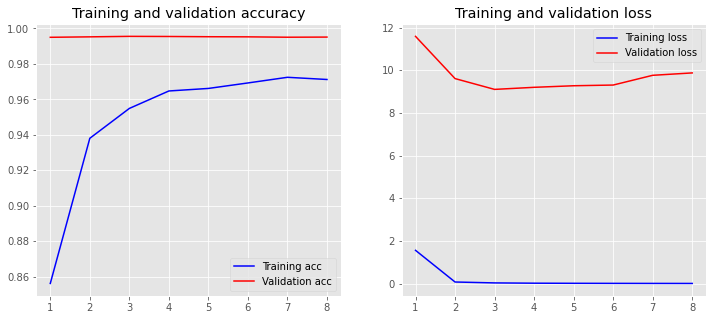

864/864 [==============================] - 68s 75ms/step
F1-score: 65.7%
Classification Report:
,precision,recall,f1-score,support
problem,0.6887340301974448,0.6142140068520436,0.6493429919137466,12551.0
test,0.7181306581844874,0.6513537505548158,0.683114162690562,9012.0
treatment,0.6827503015681544,0.6074916818718472,0.6429261089339467,9317.0
micro avg,0.6956285931228984,0.6230246113989637,0.6573278439277722,30880.0
macro avg,0.6965383299833622,0.6243531464262355,0.6584610878460851,30880.0
weighted avg,0.6955077352421382,0.6230246113989637,0.657262671069118,30880.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Converted 10682 words (18210 misses)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 204, 100)          2889200   
                                                                 
 bidirectional_22 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_22 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_22 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,051,456
Trainable params: 3,051,456
Non-trai

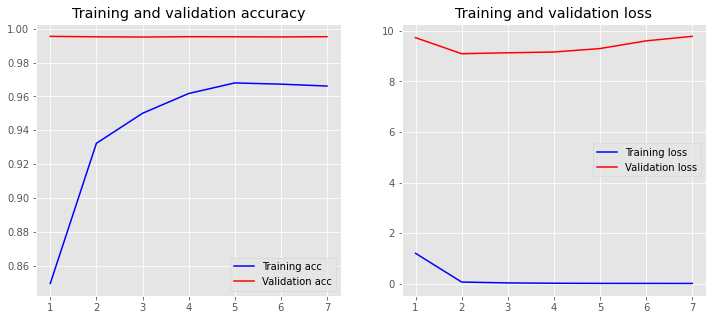

864/864 [==============================] - 68s 75ms/step
F1-score: 64.4%
Classification Report:
,precision,recall,f1-score,support
problem,0.707145536384096,0.6008286192335273,0.6496661641180271,12551.0
test,0.67388925366601,0.6833111407012872,0.6785674931129476,9012.0
treatment,0.7130111524163569,0.5146506386175808,0.5978057598803141,9317.0
micro avg,0.6971764617182493,0.5988989637305699,0.6443116693086208,30880.0
macro avg,0.6980153141554877,0.599596799517465,0.6420131390370963,30880.0
weighted avg,0.699209795604212,0.5988989637305699,0.6424535796173617,30880.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Converted 10688 words (18224 misses)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 204, 100)          2891200   
                                                                 
 bidirectional_23 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_23 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_23 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,053,456
Trainable params: 3,053,456
Non-trai

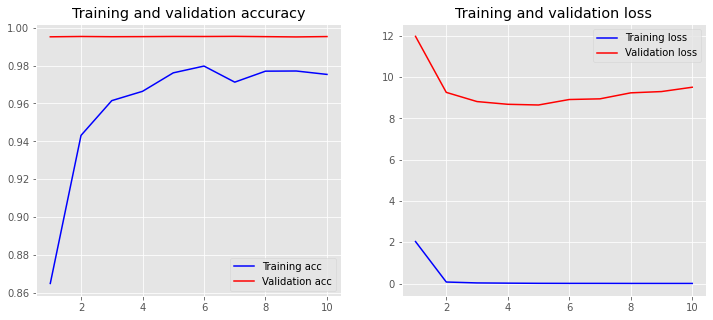

864/864 [==============================] - 68s 75ms/step
F1-score: 64.1%
Classification Report:
,precision,recall,f1-score,support
problem,0.6544393134094275,0.5984383714445064,0.625187281504911,12551.0
test,0.7396069538926682,0.6514647137150466,0.6927433628318584,9012.0
treatment,0.7005954853898352,0.5429859396801545,0.6118031200870722,9317.0
micro avg,0.6923336837362968,0.5971826424870467,0.6412476528270395,30880.0
macro avg,0.6982139175639769,0.5976296749465692,0.6432445881412805,30880.0
weighted avg,0.6932206550666951,0.5971826424870467,0.6408645863296664,30880.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Converted 10692 words (18197 misses)
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 204, 100)          2888900   
                                                                 
 bidirectional_24 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_24 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_24 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,051,156
Trainable params: 3,051,156
Non-trai

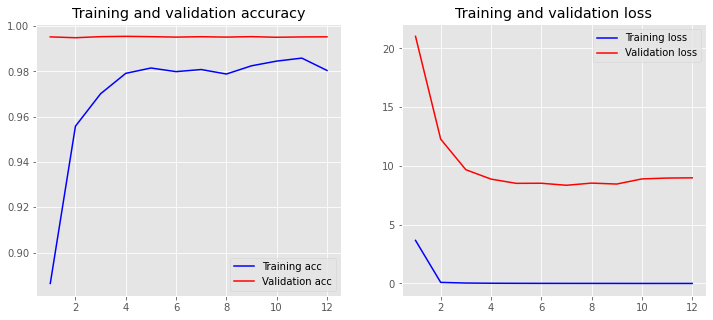

864/864 [==============================] - 69s 77ms/step
F1-score: 63.2%
Classification Report:
,precision,recall,f1-score,support
problem,0.620927369716865,0.6028204923910445,0.6117399741267788,12551.0
test,0.6836677502522138,0.6767643142476698,0.6801985167010539,9012.0
treatment,0.6523966337358215,0.5741118385746485,0.6107558803379768,9317.0
micro avg,0.6488312574645965,0.6157383419689119,0.6318517903132008,30880.0
macro avg,0.6523305845683001,0.6178988817377876,0.6342314570552698,30880.0
weighted avg,0.6487322739347788,0.6157383419689119,0.6314219554690423,30880.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Converted 10690 words (18192 misses)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 204, 100)          2888200   
                                                                 
 bidirectional_25 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_25 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_25 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,050,456
Trainable params: 3,050,456
Non-trai

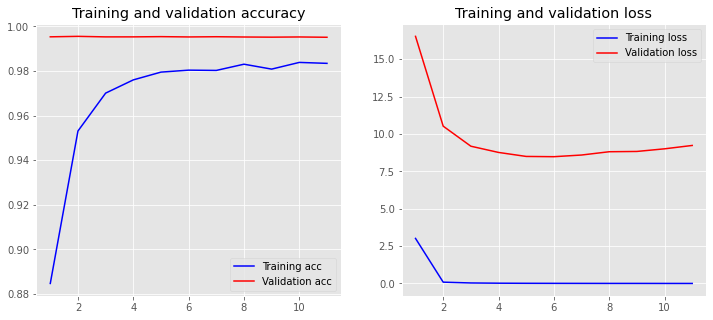

864/864 [==============================] - 67s 74ms/step
F1-score: 62.2%
Classification Report:
,precision,recall,f1-score,support
problem,0.6128668171557562,0.6056887897378694,0.6092566619915849,12551.0
test,0.7171244146310594,0.6287172658677319,0.6700171465736416,9012.0
treatment,0.6922191859628937,0.5165825909627563,0.591641057160418,9317.0
micro avg,0.6633281972265023,0.5855246113989637,0.6220028208744711,30880.0
macro avg,0.6740701392499031,0.5836628821894525,0.6236382885752149,30880.0
weighted avg,0.6672351943780208,0.5855246113989637,0.6216740485473334,30880.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Converted 10660 words (18224 misses)
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 204, 100)          2888400   
                                                                 
 bidirectional_26 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_26 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_26 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,050,656
Trainable params: 3,050,656
Non-trai

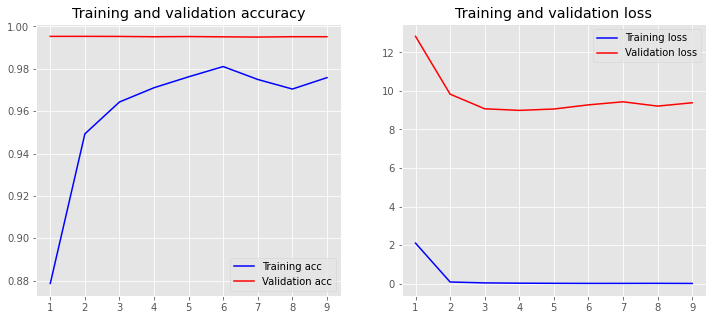

864/864 [==============================] - 68s 75ms/step
F1-score: 63.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.6419441787670638,0.5882399808780177,0.6139198403459171,12551.0
test,0.6777039413382218,0.656347092765202,0.6668545659526494,9012.0
treatment,0.7077159630975678,0.5434152624235269,0.6147774877056645,9317.0
micro avg,0.6705255085271884,0.5945919689119171,0.6302799375246726,30880.0
macro avg,0.6757880277342845,0.5960007786889155,0.6318506313347436,30880.0
weighted avg,0.6722247064516033,0.5945919689119171,0.6296270439605103,30880.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Converted 10691 words (18216 misses)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 204, 100)          2890700   
                                                                 
 bidirectional_27 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_27 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_27 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,052,956
Trainable params: 3,052,956
Non-trai

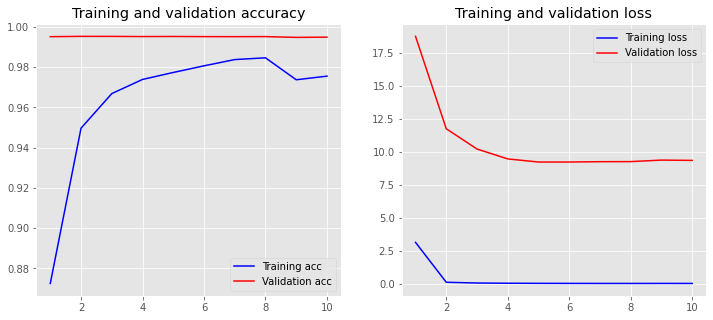

864/864 [==============================] - 69s 76ms/step
F1-score: 63.3%
Classification Report:
,precision,recall,f1-score,support
problem,0.6357471963835521,0.5826627360369692,0.6080485574124886,12551.0
test,0.6721619827395442,0.6741011984021305,0.6731301939058173,9012.0
treatment,0.6973180076628352,0.5664913598797896,0.6251332464763709,9317.0
micro avg,0.664034151547492,0.6044689119170984,0.6328530259365994,30880.0
macro avg,0.6684090622619773,0.6077517647729631,0.6354373325982255,30880.0
weighted avg,0.6649513836675314,0.6044689119170984,0.6321966712753795,30880.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 10401
Points in y_train after augmentation: 10401
Converted 10676 words (18196 misses)
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 204, 100)          2887200   
                                                                 
 bidirectional_28 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_28 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_28 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,049,456
Trainable params: 3,049,456
Non-trai

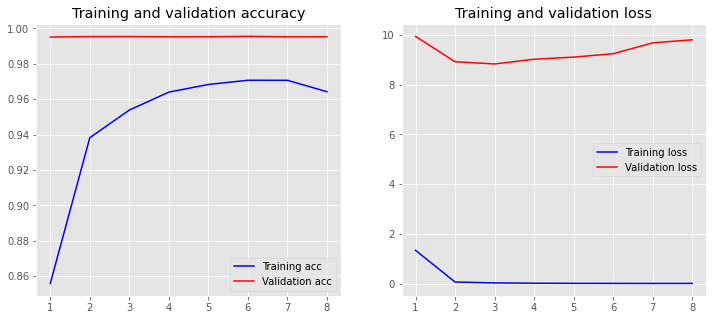

864/864 [==============================] - 69s 75ms/step
F1-score: 65.5%
Classification Report:
,precision,recall,f1-score,support
problem,0.6787277762887519,0.605290415106366,0.6399090296495956,12551.0
test,0.7552601006841358,0.6492454505104306,0.6982516856614357,9012.0
treatment,0.746433770014556,0.5503917570033272,0.633594860072898,9317.0
micro avg,0.7197210383572259,0.6015544041450778,0.6553536778973365,30880.0
macro avg,0.7268072156624813,0.6016425408733747,0.6572518584613097,30880.0
weighted avg,0.7214909256085225,0.6015544041450778,0.6550306260884754,30880.0



In [15]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Converted 10953 words (18335 misses)
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 204, 100)          2928800   
                                                                 
 bidirectional_29 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_29 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_29 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,091,056
Trainable params: 3,091,056
Non-trai

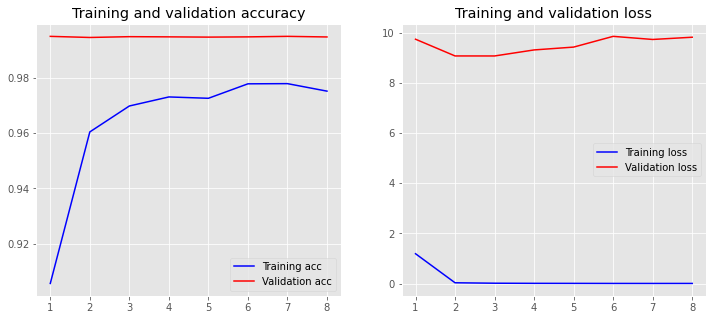

864/864 [==============================] - 68s 75ms/step
F1-score: 61.3%
Classification Report:
,precision,recall,f1-score,support
problem,0.6527684804437219,0.5438610469285315,0.5933588317107092,12551.0
test,0.7461632486758115,0.6096316023080337,0.6710229007633588,9012.0
treatment,0.6920343500148061,0.5016636256305678,0.5816688445025201,9317.0
micro avg,0.6915439081956539,0.5503238341968912,0.6129043892235005,30880.0
macro avg,0.6969886930447798,0.5517187582890444,0.6153501923255295,30880.0
weighted avg,0.6918719052527045,0.5503238341968912,0.6124972053986555,30880.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Converted 10965 words (18314 misses)
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 204, 100)          2927900   
                                                                 
 bidirectional_30 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_30 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_30 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,090,156
Trainable params: 3,090,156
Non-trai

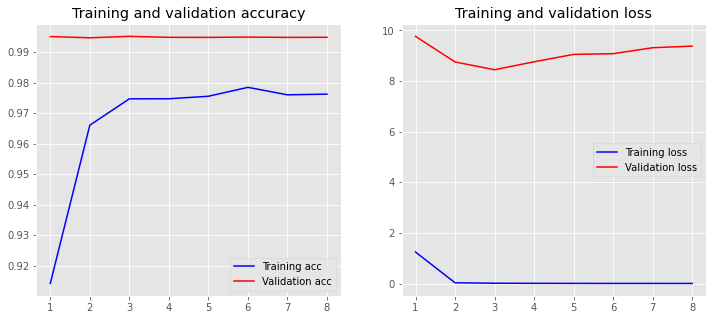

864/864 [==============================] - 67s 74ms/step
F1-score: 63.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.6485637342908438,0.5756513425225082,0.6099362627157993,12551.0
test,0.7451131687242798,0.6429205503772747,0.6902549440076245,9012.0
treatment,0.7104725588996323,0.5599441880433615,0.6262905162064826,9317.0
micro avg,0.6944666590502304,0.5905440414507772,0.6383030854582684,30880.0
macro avg,0.7013831539715852,0.5928386936477148,0.6421605743099689,30880.0
weighted avg,0.6954195640186356,0.5905440414507772,0.6383107619248222,30880.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Converted 10940 words (18303 misses)
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 204, 100)          2924300   
                                                                 
 bidirectional_31 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_31 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_31 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,086,556
Trainable params: 3,086,556
Non-trai

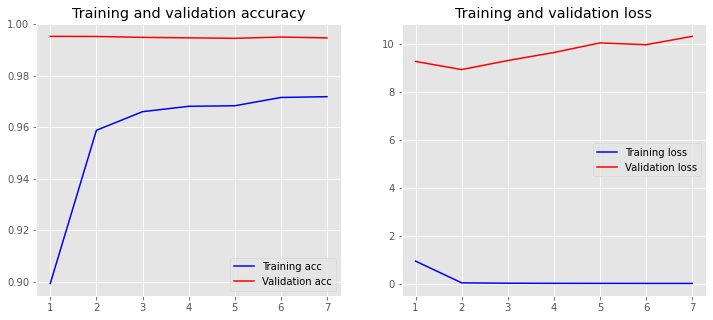

864/864 [==============================] - 67s 74ms/step
F1-score: 64.1%
Classification Report:
,precision,recall,f1-score,support
problem,0.689877121123464,0.5636204286511035,0.620390265292699,12551.0
test,0.7547628180539573,0.6550155348424324,0.7013604229786728,9012.0
treatment,0.6456890374970146,0.5803370183535472,0.6112712678763212,9317.0
micro avg,0.6950735377518998,0.5953367875647668,0.6413507997697501,30880.0
macro avg,0.6967763255581453,0.5996576606156944,0.6443406520492311,30880.0
weighted avg,0.6954810565376471,0.5953367875647668,0.6412691954137354,30880.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Converted 10932 words (18283 misses)
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 204, 100)          2921500   
                                                                 
 bidirectional_32 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_32 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_32 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,083,756
Trainable params: 3,083,756
Non-trai

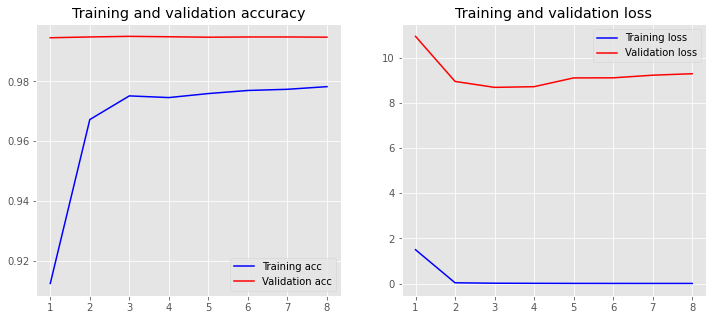

864/864 [==============================] - 67s 73ms/step
F1-score: 62.4%
Classification Report:
,precision,recall,f1-score,support
problem,0.6698301224257379,0.5623456298302925,0.6113998613998615,12551.0
test,0.755085653104925,0.6260541500221927,0.6845425867507886,9012.0
treatment,0.6391554702495201,0.5361167757861973,0.5831193088956339,9317.0
micro avg,0.6852153035935564,0.5730246113989638,0.6241182279909707,30880.0
macro avg,0.6880237485933943,0.5748388518795609,0.626353919015428,30880.0
weighted avg,0.6854560002804987,0.5730246113989638,0.6242130846246241,30880.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Converted 10947 words (18328 misses)
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 204, 100)          2927500   
                                                                 
 bidirectional_33 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_33 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_33 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,089,756
Trainable params: 3,089,756
Non-trai

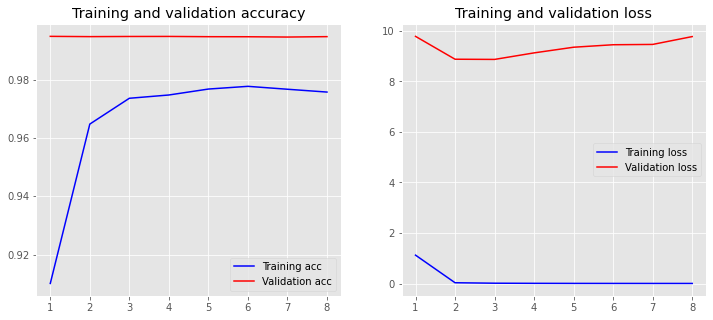

864/864 [==============================] - 66s 73ms/step
F1-score: 61.7%
Classification Report:
,precision,recall,f1-score,support
problem,0.6453779922414609,0.5434626722970282,0.5900519031141869,12551.0
test,0.7304909560723514,0.6273857079449623,0.6750238777459407,9012.0
treatment,0.6937437651417985,0.5224857786841258,0.5960573037835191,9317.0
micro avg,0.6847903340440654,0.5616256476683937,0.6171227271109845,30880.0
macro avg,0.6898709044852036,0.5644447196420388,0.6203776948812155,30880.0
weighted avg,0.68481004975948,0.5616256476683937,0.6166619987559464,30880.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Converted 10977 words (18316 misses)
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, 204, 100)          2929300   
                                                                 
 bidirectional_34 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_34 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_34 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,091,556
Trainable params: 3,091,556
Non-trai

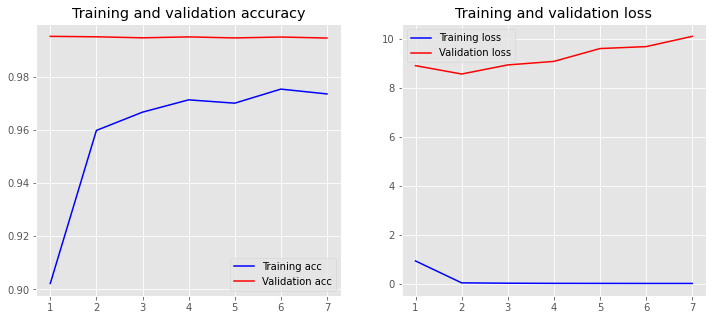

864/864 [==============================] - 66s 72ms/step
F1-score: 63.0%
Classification Report:
,precision,recall,f1-score,support
problem,0.709607694801686,0.5231455660903513,0.602274811961108,12551.0
test,0.7405607476635514,0.6594540612516645,0.69765803838704,9012.0
treatment,0.6719255663430421,0.5348288075560803,0.5955895535767645,9317.0
micro avg,0.7083502065279015,0.5664507772020725,0.6295030050023392,30880.0
macro avg,0.7073646696027599,0.572476144966032,0.6318408013083041,30880.0
weighted avg,0.7072717013283034,0.5664507772020725,0.6280943418893324,30880.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Converted 10960 words (18310 misses)
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 204, 100)          2927000   
                                                                 
 bidirectional_35 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_35 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_35 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,089,256
Trainable params: 3,089,256
Non-trai

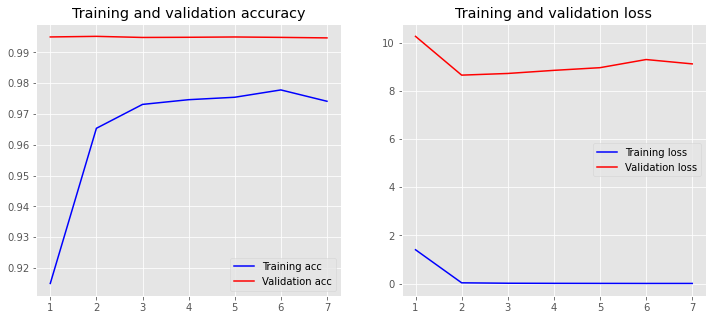

864/864 [==============================] - 66s 72ms/step
F1-score: 63.7%
Classification Report:
,precision,recall,f1-score,support
problem,0.6644258218988858,0.5748545932595013,0.616403246475865,12551.0
test,0.7583356296500413,0.6107412339103417,0.6765826674861709,9012.0
treatment,0.6742927429274292,0.5883868197917784,0.6284174929787356,9317.0
micro avg,0.6934506800777231,0.589410621761658,0.6372118262817933,30880.0
macro avg,0.6990180648254521,0.5913275489872071,0.6404678023135905,30880.0
weighted avg,0.6948094129181978,0.589410621761658,0.637590865543615,30880.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Converted 10937 words (18324 misses)
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 204, 100)          2926100   
                                                                 
 bidirectional_36 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_36 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_36 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,088,356
Trainable params: 3,088,356
Non-trai

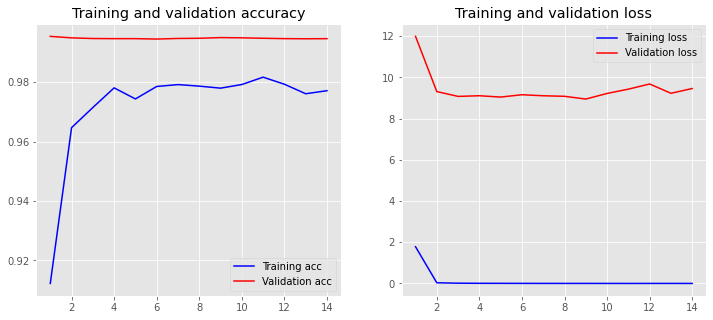

864/864 [==============================] - 66s 73ms/step
F1-score: 62.7%
Classification Report:
,precision,recall,f1-score,support
problem,0.6549444231506324,0.5445781212652379,0.5946839517988428,12551.0
test,0.73290355201618,0.643364403018198,0.6852212964604384,9012.0
treatment,0.707982012366498,0.5407319952774499,0.6131564534777583,9317.0
micro avg,0.6939873542002121,0.5722474093264248,0.6272651438510551,30880.0
macro avg,0.6986099958444368,0.5762248398536286,0.6310205672456798,30880.0
weighted avg,0.6936982731525927,0.5722474093264248,0.6266797694229604,30880.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Converted 10936 words (18316 misses)
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, 204, 100)          2925200   
                                                                 
 bidirectional_37 (Bidirecti  (None, 204, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_37 (TimeDi  (None, 204, 7)           1407      
 stributed)                                                      
                                                                 
 crf_37 (CRF)                (None, 204, 7)            49        
                                                                 
Total params: 3,087,456
Trainable params: 3,087,456
Non-trai

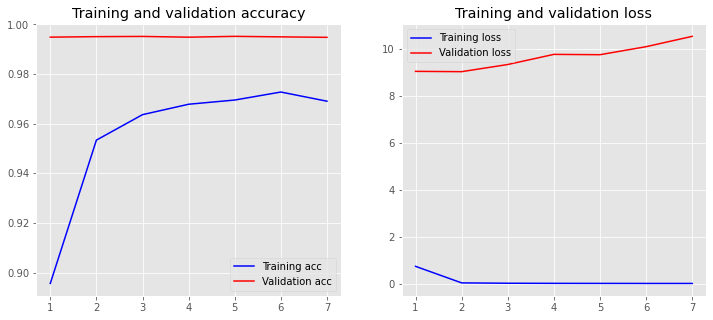

864/864 [==============================] - 66s 73ms/step
F1-score: 63.1%
Classification Report:
,precision,recall,f1-score,support
problem,0.6537693697119498,0.547924468169867,0.5961855223233636,12551.0
test,0.7545320263193233,0.6235019973368842,0.6827875326569051,9012.0
treatment,0.7142269736842105,0.5593002039283032,0.627340034912418,9317.0
micro avg,0.7009342094846014,0.5734132124352331,0.6307933454454776,30880.0
macro avg,0.7075094565718278,0.5769088898116848,0.6354376966308956,30880.0
weighted avg,0.7014169266275976,0.5734132124352331,0.6308592241017994,30880.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 20802
Points in y_train after augmentation: 20802
Converted 10949 words (18335 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 204, 100)          2928400   
                                                                 
 bidirectional (Bidirectiona  (None, 204, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 204, 7)           1407      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 204, 7)            49        
                                                                 
Total params: 3,090,656
Trainable params: 3,090,656
Non-trainab

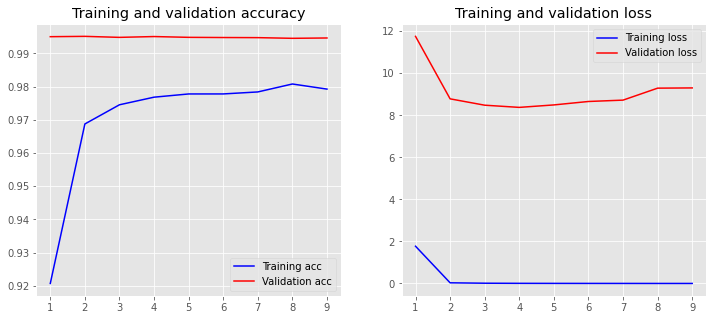

864/864 [==============================] - 65s 72ms/step
F1-score: 61.8%
Classification Report:
,precision,recall,f1-score,support
problem,0.6707172495554238,0.540913074655406,0.5988620826533763,12551.0
test,0.6927752293577981,0.6703284509542832,0.6813670200766975,9012.0
treatment,0.6663357912648894,0.5043468927766448,0.574134033844462,9317.0
micro avg,0.6769521896964548,0.5676489637305699,0.6175009687533026,30880.0
macro avg,0.6766094233927037,0.5718628061287779,0.6181210455248453,30880.0
weighted avg,0.6758326791890407,0.5676489637305699,0.6154794163744357,30880.0



In [13]:
number_of_training_models = 1
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)